In [1]:
# Importar las librerías necesarias
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as sns  
from pathlib import Path
import glob
import time

from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA  
from sklearn.cluster import KMeans



In [2]:
# Establecer el random seed
random_seed = 42
np.random.seed(random_seed)

# Cargar y Explorar los Datos
Carga el archivo parquet usando pandas y realiza una exploración inicial de los datos, incluyendo estadísticas descriptivas y visualización de distribuciones.

In [3]:
# Cargar todos los archivos parquet que contienen 'merged_inmuebles24_departamentos_duckdb'
data_folder = '../../data/processed/'
pattern = f"{data_folder}*merged_inmuebles24_departamentos_duckdb*.parquet"

In [4]:

# Buscar todos los archivos que coincidan con el patrón
files = glob.glob(pattern)


In [5]:

print(f"Archivos encontrados: {len(files)}")
for file in files:
    print(f"  - {Path(file).name}")


Archivos encontrados: 6
  - merged_inmuebles24_departamentos_duckdb_2025-10-11.parquet
  - merged_inmuebles24_departamentos_duckdb_2025-08-31.parquet
  - merged_inmuebles24_departamentos_duckdb_2025-09-27.parquet
  - merged_inmuebles24_departamentos_duckdb_2025-10-05.parquet
  - merged_inmuebles24_departamentos_duckdb_2025-09-14.parquet
  - merged_inmuebles24_departamentos_duckdb_2025-09-20.parquet


In [6]:

# Leer y concatenar todos los archivos
if len(files) == 0:
    raise FileNotFoundError(f"No se encontraron archivos con el patrón: {pattern}")


In [7]:

dfs = []
for file in files:
    temp_df = pd.read_parquet(file)
    temp_df['source_file'] = Path(file).name  # Agregar columna con nombre del archivo fuente
    dfs.append(temp_df)
    print(f"Cargado: {Path(file).name} - {len(temp_df)} registros")


Cargado: merged_inmuebles24_departamentos_duckdb_2025-10-11.parquet - 5975 registros
Cargado: merged_inmuebles24_departamentos_duckdb_2025-08-31.parquet - 5858 registros
Cargado: merged_inmuebles24_departamentos_duckdb_2025-09-27.parquet - 5986 registros
Cargado: merged_inmuebles24_departamentos_duckdb_2025-10-05.parquet - 5843 registros
Cargado: merged_inmuebles24_departamentos_duckdb_2025-09-14.parquet - 6040 registros
Cargado: merged_inmuebles24_departamentos_duckdb_2025-09-20.parquet - 5684 registros


In [8]:
# Concatenar todos los DataFrames
df = pd.concat(dfs, ignore_index=True)

In [9]:
df.shape

(35386, 155)

### Análisis de duplicados

In [10]:
# Contar duplicados completos (todas las columnas)
duplicados_completos = df.duplicated().sum()
print(f"\n1. Duplicados completos (todas las columnas): {duplicados_completos}")
print(f"   Porcentaje: {(duplicados_completos/len(df)*100):.2f}%")



1. Duplicados completos (todas las columnas): 0
   Porcentaje: 0.00%


In [11]:
# Identificar columnas clave para duplicados (excluyendo source_file)
cols_clave = [col for col in df.columns if col != 'source_file']
cols_clave


['precio_mxn',
 'lote_m2',
 'recamaras',
 'baños',
 'estacionamiento',
 'es_amueblado',
 'es_penthouse',
 'direccion',
 'colonia',
 'cp',
 'municipio',
 'Título',
 'Enlace',
 'latitud',
 'longitud',
 'colonia_std',
 'ENTIDAD',
 'NOM_ENT',
 'MUN',
 'NOM_MUN',
 'LOC',
 'NOM_LOC',
 'AGEB',
 'MZA',
 'POBTOT',
 'POBFEM',
 'POBMAS',
 'P_0A2',
 'P_0A2_F',
 'P_0A2_M',
 'P_18YMAS',
 'P_18YMAS_F',
 'P_18YMAS_M',
 'P_3A5',
 'P_3A5_F',
 'P_3A5_M',
 'P_6A11',
 'P_6A11_F',
 'P_6A11_M',
 'P_8A14',
 'P_8A14_F',
 'P_8A14_M',
 'P_12A14',
 'P_12A14_F',
 'P_12A14_M',
 'P_15A17',
 'P_15A17_F',
 'P_15A17_M',
 'P_18A24',
 'P_18A24_F',
 'P_18A24_M',
 'P_15A49_F',
 'P_60YMAS',
 'P_60YMAS_F',
 'P_60YMAS_M',
 'POB65_MAS',
 'P18YM_PB',
 'P18YM_PB_F',
 'P18YM_PB_M',
 'TOTHOG',
 'HOGJEF_F',
 'HOGJEF_M',
 'POBHOG',
 'PHOGJEF_F',
 'PHOGJEF_M',
 'VIVTOT',
 'TVIVHAB',
 'TVIVPAR',
 'VIVPAR_HAB',
 'VIVPARH_CV',
 'TVIVPARHAB',
 'VIVPAR_DES',
 'VIVPAR_UT',
 'OCUPVIVPAR',
 'PROM_OCUP',
 'PRO_OCUP_C',
 'VPH_1DOR',
 'VPH_2YMA

In [12]:
# Duplicados por columnas clave
duplicados_clave = df.duplicated(subset=cols_clave).sum()
print(f"\n2. Duplicados por columnas clave (excluyendo source_file): {duplicados_clave}")
print(f"   Porcentaje: {(duplicados_clave/len(df)*100):.2f}%")



2. Duplicados por columnas clave (excluyendo source_file): 13951
   Porcentaje: 39.43%


In [13]:
# Si hay duplicados, mostrar ejemplos
if duplicados_clave > 0:
    print("\n3. Ejemplos de registros duplicados:")
    mask_duplicados = df.duplicated(subset=cols_clave, keep=False)
    ejemplos_duplicados = df[mask_duplicados].sort_values(by=cols_clave[:3]).head(10)
    display(ejemplos_duplicados[['precio_mxn', 'lote_m2', 'direccion', 'source_file'][:min(5, len(ejemplos_duplicados.columns))]])
    
    # Contar duplicados por archivo fuente
    print("\n4. Distribución de duplicados por archivo fuente:")
    duplicados_por_archivo = df[mask_duplicados].groupby('source_file').size().sort_values(ascending=False)
    print(duplicados_por_archivo)



3. Ejemplos de registros duplicados:


precio_mxn  lote_m2                                          direccion  \
12479      2900.0       30  jardin azaleas jardines de san lorenzo tezonco...   
25286      2900.0       30  jardin azaleas jardines de san lorenzo tezonco...   
31143      2900.0       30  jardin azaleas jardines de san lorenzo tezonco...   
1409       2950.0       12             calle tepexpan la candelaria  coyoacan   
7647       2950.0       12             calle tepexpan la candelaria  coyoacan   
13006      2950.0       12             calle tepexpan la candelaria  coyoacan   
18554      2950.0       12             calle tepexpan la candelaria  coyoacan   
24899      2950.0       12             calle tepexpan la candelaria  coyoacan   
31218      2950.0       12             calle tepexpan la candelaria  coyoacan   
1204       3000.0       16  sur gabriel ramos millan seccion bramadero  iz...   

                                             source_file  
12479  merged_inmuebles24_departamentos_duckdb_2025-0...  
25286  merged_inmuebles24_departamentos_duckdb_2025-0...  
31143  merged_inmuebles24_departamentos_duckdb_2025-0...  
1409   merged_inmuebles24_departamentos_duckdb_2025-1...  
7647   merged_inmuebles24_departamentos_duckdb_2025-0...  
13006  merged_inmuebles24_departamentos_duckdb_2025-0...  
18554  merged_inmuebles24_departamentos_duckdb_2025-1...  
24899  merged_inmuebles24_departamentos_duckdb_2025-0...  
31218  merged_inmuebles24_departamentos_duckdb_2025-0...  
1204   merged_inmuebles24_departamentos_duckdb_2025-1...


4. Distribución de duplicados por archivo fuente:
source_file
merged_inmuebles24_departamentos_duckdb_2025-09-20.parquet    3926
merged_inmuebles24_departamentos_duckdb_2025-09-27.parquet    3892
merged_inmuebles24_departamentos_duckdb_2025-09-14.parquet    3702
merged_inmuebles24_departamentos_duckdb_2025-10-05.parquet    3628
merged_inmuebles24_departamentos_duckdb_2025-10-11.parquet    3022
merged_inmuebles24_departamentos_duckdb_2025-08-31.parquet    2604
dtype: int64


In [14]:
# Eliminar duplicados si existen
if duplicados_clave > 0:
    print(f"\n5. Eliminando {duplicados_clave} duplicados...")
    df_original_len = len(df)
    df = df.drop_duplicates(subset=cols_clave, keep='first')
    print(f"   Registros antes: {df_original_len}")
    print(f"   Registros después: {len(df)}")
    print(f"   Registros eliminados: {df_original_len - len(df)}")


5. Eliminando 13951 duplicados...
   Registros antes: 35386
   Registros después: 21435
   Registros eliminados: 13951


### Análisis de Nulos

In [15]:
# Contar nulos por columna
nulos_por_columna = df.isnull().sum().sort_values(ascending=False)
porcentaje_nulos = (nulos_por_columna / len(df) * 100).round(2)

In [16]:
# Crear DataFrame de resumen
resumen_nulos = pd.DataFrame({
    'Valores_Nulos': nulos_por_columna,
    'Porcentaje': porcentaje_nulos,
    'Tipo_Dato': df.dtypes
})

In [17]:
# Filtrar solo columnas con nulos
resumen_nulos_con_datos = resumen_nulos[resumen_nulos['Valores_Nulos'] > 0]

print(f"\n1. Resumen general:")
print(f"   Total de columnas: {len(df.columns)}")
print(f"   Columnas con nulos: {len(resumen_nulos_con_datos)}")
print(f"   Columnas sin nulos: {len(df.columns) - len(resumen_nulos_con_datos)}")


1. Resumen general:
   Total de columnas: 155
   Columnas con nulos: 141
   Columnas sin nulos: 14


In [18]:
# Exploración inicial de los datos
# Mostrar las primeras filas del DataFrame
print("Primeras filas del DataFrame:")
df.head()


Primeras filas del DataFrame:


precio_mxn  lote_m2  recamaras  baños  estacionamiento  es_amueblado  \
0     18000.0      130        2.0    1.0              1.0             0   
1     30000.0      198        2.0    2.0              2.0             0   
2     23500.0      110        2.0    2.0              1.0             1   
3     14000.0       59        2.0    1.0              1.0             0   
4     14000.0       30        1.0    1.0              1.0             1   

   es_penthouse                                          direccion  \
0             0         rio becerra 135 8 de agosto  benito juarez   
1             0     avenida rio mixcoac 206 acacias  benito juarez   
2             0  av. san francisco  col. del valle actipan  ben...   
3             0              calle 2 agricola pantitlan  iztacalco   
4             0  av. tamaulipas 257 alvaro obregon  ciudad de m...   

              colonia    cp  ...  \
0         8 de agosto  1180  ...   
1             acacias  3240  ...   
2             actipan  3230  ...   
3  agricola pantitlan  8100  ...   
4      alvaro obregon  9230  ...   

                                             address  \
0  {'road': 'Calle Martell', 'neighbourhood': 'Co...   
1  {'road': 'Calle 1', 'neighbourhood': 'Colonia ...   
2  {'road': 'José María Rico', 'neighbourhood': '...   
3  {'house_number': '116', 'road': 'Calle 2', 'ne...   
4  {'road': 'Avenida Congreso de la Unión', 'neig...   

                           road quarter              borough  postcode  \
0                 Calle Martell    None       Álvaro Obregón     01180   
1                       Calle 1    None        Benito Juárez     03240   
2               José María Rico    None        Benito Juárez     03240   
3                       Calle 2    None            Iztacalco     08100   
4  Avenida Congreso de la Unión    None  Venustiano Carranza     15990   

  longitud_1  latitud_1       neighbourhood distancia  \
0 -99.189077  19.394770         8 de agosto  0.008476   
1 -99.175132  19.363520             acacias  0.000234   
2 -99.176422  19.368233             actipan  0.000330   
3 -99.067143  19.409103  agricola pantitlan  0.000125   
4 -99.121470  19.412086      alvaro obregon  0.153109   

                                         source_file  
0  merged_inmuebles24_departamentos_duckdb_2025-1...  
1  merged_inmuebles24_departamentos_duckdb_2025-1...  
2  merged_inmuebles24_departamentos_duckdb_2025-1...  
3  merged_inmuebles24_departamentos_duckdb_2025-1...  
4  merged_inmuebles24_departamentos_duckdb_2025-1...  

[5 rows x 155 columns]

In [19]:
if len(resumen_nulos_con_datos) > 0:
    print(f"\n2. Top 20 columnas con más valores nulos:")
    display(resumen_nulos_con_datos.head(20))
    


2. Top 20 columnas con más valores nulos:


Valores_Nulos  Porcentaje Tipo_Dato
AGEB                 1892        8.83    object
AGEB_fm              1892        8.83    object
CVEFT                1892        8.83    object
CVEREF1              1892        8.83    object
CVEREF2              1892        8.83    object
CVEREF3              1892        8.83    object
CVESEG               1892        8.83    object
CVESEG1              1892        8.83    object
CVESEG2              1892        8.83    object
CVESEG3              2183       10.18    object
CVEVIAL              1892        8.83    object
CVEVIAL1             1892        8.83    object
CVEVIAL2             1892        8.83    object
CVEVIAL3             2183       10.18    object
ENTIDAD              1892        8.83    object
ENTIDAD_fm           1892        8.83    object
HOGJEF_F             1892        8.83    object
HOGJEF_M             1892        8.83    object
LOC                  1892        8.83    object
LOC_fm               1892        8.83    object

In [20]:
df[df.AGEB.isnull()].head(10)

precio_mxn  lote_m2  recamaras  baños  estacionamiento  es_amueblado  \
5238     15000.0       63        1.0    1.0              2.0             0   
5239     16000.0       80        3.0    2.0              1.0             1   
5240     26000.0      161        2.0    2.0              2.0             0   
5241     10000.0       15        1.0    1.0              1.0             1   
5242     22000.0       80        3.0    2.0              2.0             0   
5243     16000.0      100        4.0    1.0              1.0             0   
5244     85000.0      325        3.0    3.0              2.0             0   
5245     45000.0      125        2.0    2.0              0.0             0   
5246     45000.0      125        2.0    2.0              0.0             0   
5247    175000.0      345        2.0    2.0              2.0             1   

      es_penthouse                                          direccion  \
5238             0  cerrada de escuela superior de guerra 81 san j...   
5239             0  privada escuela superior de guerra san jeronim...   
5240             0  av. conteras 643 san jeronimo lidice  la magda...   
5241             0  privada de antonia san jeronimo lidice  la mag...   
5242             0  270 av mexico contreras san jeronimo lidice  l...   
5243             0           av. tlahuac pueblo culhuacan  iztapalapa   
5244             0  avenida emilio castelar polanco iv seccion  po...   
5245             0    av. emilio castelar polanco iv seccion  polanco   
5246             0  avenida emilio castelar polanco iv seccion  po...   
5247             0                  solon polanco ii seccion  polanco   

                  colonia     cp  ... address  road quarter  borough  \
5238  san jeronimo lidice  10200  ...    None  None    None     None   
5239  san jeronimo lidice  10200  ...    None  None    None     None   
5240  san jeronimo lidice  10200  ...    None  None    None     None   
5241  san jeronimo lidice  10200  ...    None  None    None     None   
5242  san jeronimo lidice  10200  ...    None  None    None     None   
5243            culhuacan   9800  ...    None  None    None     None   
5244   polanco iv seccion  11550  ...    None  None    None     None   
5245   polanco iv seccion  11550  ...    None  None    None     None   
5246   polanco iv seccion  11550  ...    None  None    None     None   
5247   polanco ii seccion  11530  ...    None  None    None     None   

      postcode longitud_1 latitud_1 neighbourhood distancia  \
5238      None        NaN       NaN          None       NaN   
5239      None        NaN       NaN          None       NaN   
5240      None        NaN       NaN          None       NaN   
5241      None        NaN       NaN          None       NaN   
5242      None        NaN       NaN          None       NaN   
5243      None        NaN       NaN          None       NaN   
5244      None        NaN       NaN          None       NaN   
5245      None        NaN       NaN          None       NaN   
5246      None        NaN       NaN          None       NaN   
5247      None        NaN       NaN          None       NaN   

                                            source_file  
5238  merged_inmuebles24_departamentos_duckdb_2025-1...  
5239  merged_inmuebles24_departamentos_duckdb_2025-1...  
5240  merged_inmuebles24_departamentos_duckdb_2025-1...  
5241  merged_inmuebles24_departamentos_duckdb_2025-1...  
5242  merged_inmuebles24_departamentos_duckdb_2025-1...  
5243  merged_inmuebles24_departamentos_duckdb_2025-1...  
5244  merged_inmuebles24_departamentos_duckdb_2025-1...  
5245  merged_inmuebles24_departamentos_duckdb_2025-1...  
5246  merged_inmuebles24_departamentos_duckdb_2025-1...  
5247  merged_inmuebles24_departamentos_duckdb_2025-1...  

[10 rows x 155 columns]

In [21]:
df = df.dropna(subset=['AGEB'])

In [22]:
df.shape

(19543, 155)

In [23]:
df.isnull().sum().sort_values(ascending=False)

quarter        19494
longitud        7498
latitud         7498
distancia       7498
TIPOVR3          291
               ...  
P_60YMAS_F         0
P_60YMAS_M         0
POB65_MAS          0
P18YM_PB           0
source_file        0
Length: 155, dtype: int64

In [24]:
df = df.drop_duplicates(subset=['Título'])

In [25]:
df = df.dropna(subset=['latitud', 'longitud'])

In [26]:
df.shape

(8291, 155)

In [27]:
df.isnull().sum().sort_values(ascending=False)[:20]

quarter       8262
CVEVIAL3       117
CVESEG3        117
TIPOVR3        117
NOMREF3        117
road            87
lote_m2         51
VPH_BICI         0
VPH_REFRI        0
VPH_LAVAD        0
VPH_HMICRO       0
VPH_AUTOM        0
VPH_MOTO         0
VPH_RADIO        0
VPH_NDACMM       0
VPH_TV           0
VPH_PC           0
VPH_TELEF        0
VPH_CEL          0
VPH_INTER        0
dtype: int64

In [28]:
obj_cols = ['direccion','colonia','cp','neighbourhood','Título','Enlace','colonia_std','municipio',
            'ENTIDAD', 'NOM_ENT', 'MUN', 'NOM_MUN', 'LOC', 'NOM_LOC', 'AGEB', 'MZA',
            'key', 'ENTIDAD_fm', 'MUN_fm', 'LOC_fm', 'AGEB_fm',
            'MZA_fm', 'CVEVIAL', 'CVESEG', 'CVEFT', 'NOMVIAL', 'TIPOVIAL',
            'CVEVIAL1', 'CVESEG1', 'CVEREF1', 'TIPOVR1', 'NOMREF1', 'CVEVIAL2',
            'CVESEG2', 'CVEREF2', 'TIPOVR2', 'NOMREF2', 'CVEVIAL3', 'CVESEG3',
            'CVEREF3', 'TIPOVR3', 'NOMREF3', 'municipio_1', 'address', 'road',
            'quarter', 'borough', 'postcode', 'neighbourhood', 'source_file', 
            'lon', 'lat','latitud_1', 'longitud_1','distancia','latitud','longitud']

In [29]:
target = ['precio_mxn']

In [30]:
numeric_cols = list(set(df.columns) - set(obj_cols) - set(target))

In [31]:
uppercase_columns = [col for col in df[numeric_cols].columns if col.isupper()]
print("Columns with uppercase names:", uppercase_columns)

Columns with uppercase names: ['VPH_SNBIEN', 'VPH_PC', 'VPH_DSADMA', 'VPH_CVJ', 'P_15A17_F', 'P_3A5_M', 'POB65_MAS', 'P_8A14_F', 'P18YM_PB_F', 'VPH_LETR', 'TVIVPARHAB', 'TVIVPAR', 'VPH_SINTIC', 'VPH_S_ELEC', 'VPH_DRENAJ', 'P_0A2_M', 'P_60YMAS_M', 'P_15A17_M', 'VIVPAR_DES', 'VPH_RADIO', 'VIVTOT', 'VPH_AGUAFV', 'POBMAS', 'VPH_2CUART', 'P_8A14_M', 'POBTOT', 'P_18YMAS_M', 'P_0A2_F', 'P_18YMAS', 'P_15A17', 'P_18A24', 'VPH_NDACMM', 'VPH_EXCSA', 'P_3A5_F', 'VPH_2YMASD', 'OCUPVIVPAR', 'VPH_1DOR', 'P_18A24_F', 'P_3A5', 'P_18YMAS_F', 'VPH_AUTOM', 'VPH_1CUART', 'VPH_HMICRO', 'VIVPARH_CV', 'VPH_SINLTC', 'VPH_CEL', 'VPH_AEASP', 'VPH_CISTER', 'P18YM_PB', 'PHOGJEF_M', 'VPH_3YMASC', 'VPH_MOTO', 'VPH_INTER', 'P_15A49_F', 'VPH_NDEAED', 'P_12A14_M', 'VPH_STVP', 'HOGJEF_F', 'PHOGJEF_F', 'PROM_OCUP', 'VPH_C_SERV', 'P_60YMAS', 'VPH_TV', 'P_6A11_M', 'P_12A14', 'P_12A14_F', 'VPH_SINCINT', 'P_0A2', 'VIVPAR_UT', 'P_60YMAS_F', 'TVIVHAB', 'VPH_LAVAD', 'HOGJEF_M', 'VPH_NODREN', 'P_8A14', 'VPH_TINACO', 'VPH_SINRTV'

In [32]:
#porque sabemos de los datos del INEGI que no hay registros.
df[uppercase_columns] = df[uppercase_columns].fillna(0)

In [33]:
df.isnull().sum().sort_values(ascending=False)[:10]

quarter      8262
CVEVIAL3      117
CVESEG3       117
TIPOVR3       117
NOMREF3       117
road           87
lote_m2        51
VPH_BICI        0
VPH_REFRI       0
VPH_LAVAD       0
dtype: int64

In [34]:
df['lote_m2'] = df.groupby('colonia')['lote_m2'].transform(lambda x: x.fillna(int(x.mean())))

In [35]:
df[df['lote_m2'].isnull()].source_file.value_counts()

Series([], Name: count, dtype: int64)

In [36]:
# Información general del DataFrame
print("\nInformación general del DataFrame:")
df.info()


Información general del DataFrame:
<class 'pandas.core.frame.DataFrame'>
Index: 8291 entries, 0 to 33886
Columns: 155 entries, precio_mxn to source_file
dtypes: Int64(1), float64(11), int64(2), object(141)
memory usage: 9.9+ MB


In [37]:
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

In [38]:
fix_int = list(df.select_dtypes('Int64').columns)

In [39]:
fix_int

['lote_m2', 'es_amueblado', 'es_penthouse', 'POBTOT', 'VIVTOT', 'TVIVHAB']

In [40]:
df[fix_int] = df[fix_int].astype('int64')

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8291 entries, 0 to 33886
Columns: 155 entries, precio_mxn to source_file
dtypes: float64(100), int64(6), object(49)
memory usage: 9.9+ MB


In [42]:
# Estadísticas descriptivas
print("\nEstadísticas descriptivas:")
df.describe(include='all')


Estadísticas descriptivas:


precio_mxn        lote_m2    recamaras        baños  \
count     8291.000000    8291.000000  8291.000000  8291.000000   
unique            NaN            NaN          NaN          NaN   
top               NaN            NaN          NaN          NaN   
freq              NaN            NaN          NaN          NaN   
mean     37221.490040     280.645640     1.983717     1.753829   
std      29561.065994   10512.204463     0.902269     0.792803   
min         12.000000       1.000000     0.000000     0.000000   
25%      19518.000000      64.000000     1.000000     1.000000   
50%      29000.000000      90.000000     2.000000     2.000000   
75%      43000.000000     140.000000     2.000000     2.000000   
max     447840.000000  860000.000000    30.000000    12.000000   

        estacionamiento  es_amueblado  es_penthouse  \
count       8291.000000   8291.000000   8291.000000   
unique              NaN           NaN           NaN   
top                 NaN           NaN           NaN   
freq                NaN           NaN           NaN   
mean           1.348330      0.294898      0.041370   
std            0.881524      0.456024      0.199157   
min            0.000000      0.000000      0.000000   
25%            1.000000      0.000000      0.000000   
50%            1.000000      0.000000      0.000000   
75%            2.000000      1.000000      0.000000   
max           22.000000      1.000000      1.000000   

                              direccion  colonia    cp  ...  \
count                              8291     8291  8291  ...   
unique                             4529      294   269  ...   
top     polanco polanco  miguel hidalgo  hidalgo  1120  ...   
freq                                 93     2518  2529  ...   
mean                                NaN      NaN   NaN  ...   
std                                 NaN      NaN   NaN  ...   
min                                 NaN      NaN   NaN  ...   
25%                                 NaN      NaN   NaN  ...   
50%                                 NaN      NaN   NaN  ...   
75%                                 NaN      NaN   NaN  ...   
max                                 NaN      NaN   NaN  ...   

                                                  address        road  \
count                                                8291        8204   
unique                                               1183         801   
top     {'amenity': 'Colegio Americano', 'road': 'Call...  Calle Tula   
freq                                                 2283        2283   
mean                                                  NaN         NaN   
std                                                   NaN         NaN   
min                                                   NaN         NaN   
25%                                                   NaN         NaN   
50%                                                   NaN         NaN   
75%                                                   NaN         NaN   
max                                                   NaN         NaN   

           quarter         borough  postcode   longitud_1    latitud_1  \
count           29            8291      8291  8291.000000  8291.000000   
unique           4              15       305          NaN          NaN   
top     Tlatelolco  Álvaro Obregón     01120          NaN          NaN   
freq            16            3508      2526          NaN          NaN   
mean           NaN             NaN       NaN   -99.188927    19.397808   
std            NaN             NaN       NaN     0.041907     0.033693   
min            NaN             NaN       NaN   -99.304810    19.206014   
25%            NaN             NaN       NaN   -99.206255    19.376291   
50%            NaN             NaN       NaN   -99.182552    19.400303   
75%            NaN             NaN       NaN   -99.163803    19.423057   
max            NaN             NaN       NaN   -99.008577    19.517450   

       neighbourhood    distancia 

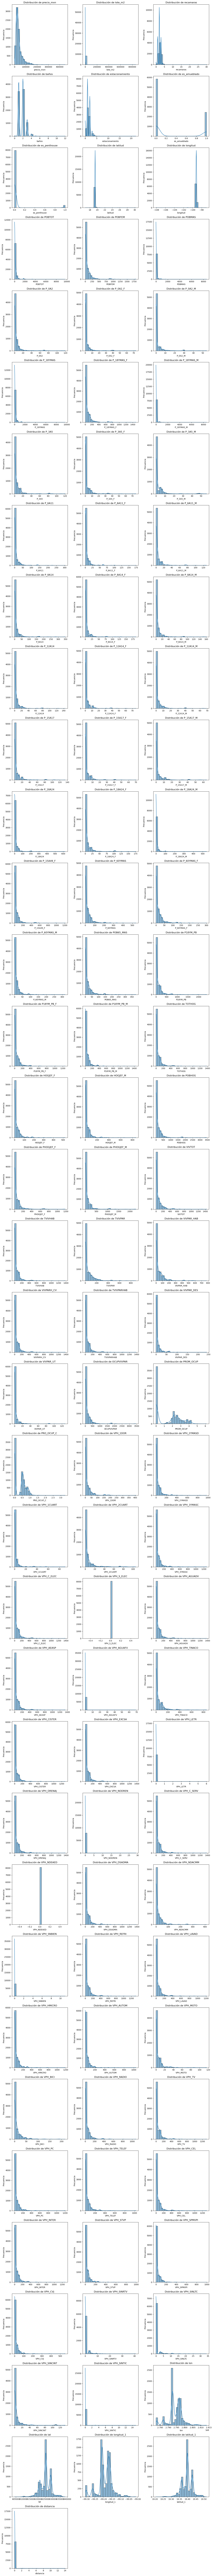

In [43]:
# Visualización de distribuciones
# Seleccionar columnas numéricas
numeric_columns = df.select_dtypes(include=[np.number]).columns

# Crear subplots para las columnas numéricas
num_cols = len(numeric_columns)
fig, axes = plt.subplots(nrows=(num_cols // 3) + 1, ncols=3, figsize=(15, 5 * ((num_cols // 3) + 1)))
axes = axes.flatten()

for i, column in enumerate(numeric_columns):
    sns.histplot(df[column], kde=True, bins=30, ax=axes[i])
    axes[i].set_title(f"Distribución de {column}")
    axes[i].set_xlabel(column)
    axes[i].set_ylabel("Frecuencia")

# Eliminar ejes vacíos si hay menos subplots que espacios
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

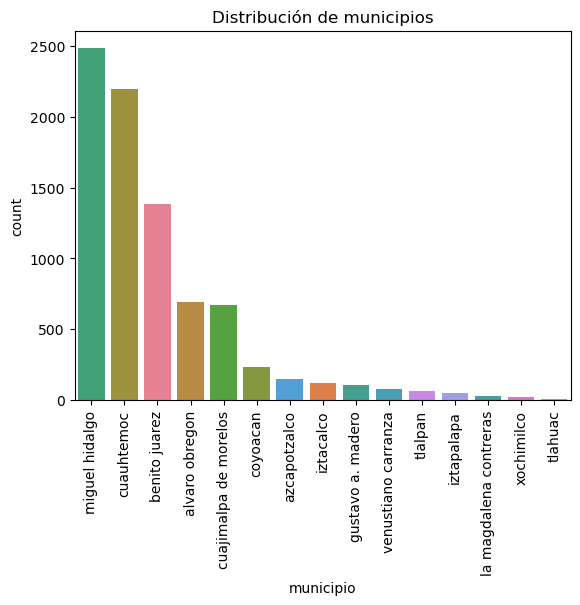

In [44]:
municipio_order = df['municipio'].value_counts().index

sns.countplot(data=df, x='municipio', order=municipio_order, hue='municipio')
plt.xticks(rotation=90)
plt.title('Distribución de municipios')
plt.show()

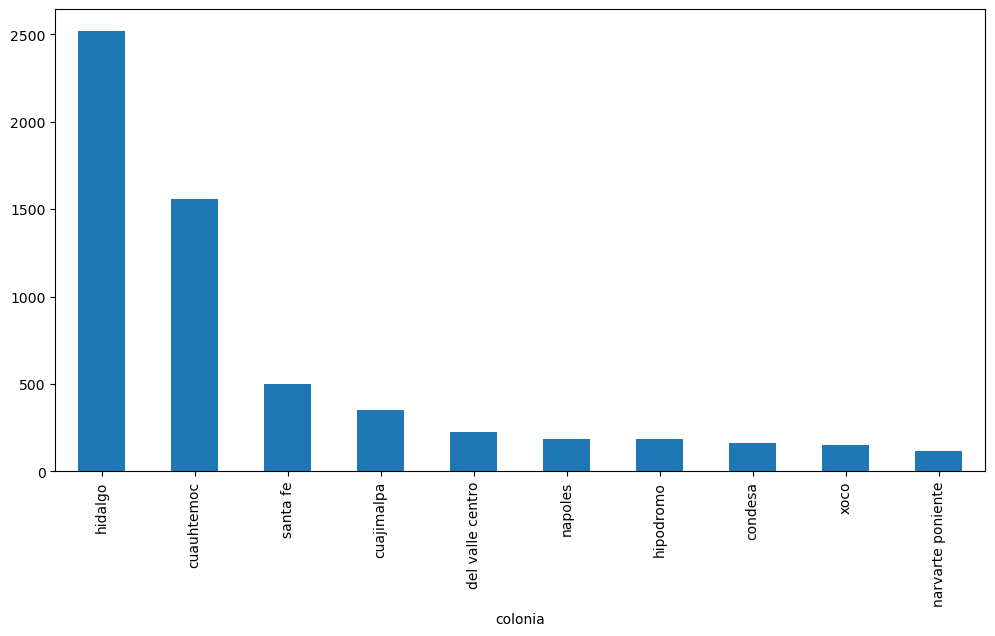

In [45]:
df.colonia.value_counts().head(10).plot(kind='bar', figsize=(12,6))
plt.show()

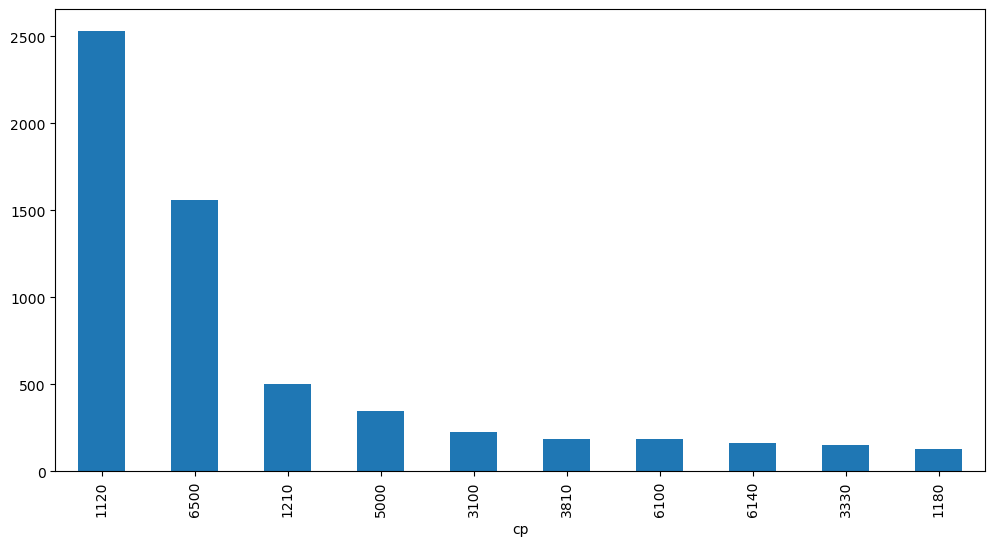

In [46]:
# Un CP puede contener varias colonias, así que nos quedamos sólo con colonias
df.cp.value_counts().head(10).plot(kind='bar', figsize=(12,6))
plt.show()

In [47]:
top10_cols= list(df.colonia.value_counts().head(10).index)

In [48]:
df['colonia_top10'] = df['colonia'].where(df['colonia'].isin(top10_cols), 'otros')

/var/folders/c7/mdvpp7_n2dj49y88d6cj51kc0000gn/T/ipykernel_12326/2711523768.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['colonia_top10'] = df['colonia'].where(df['colonia'].isin(top10_cols), 'otros')


# Preprocesamiento de Datos
Aplica técnicas de limpieza de datos, manejo de valores nulos y codificación de variables categóricas.

In [49]:
# Identificar valores nulos en el DataFrame
print("\nValores nulos por columna:")
df.isnull().sum().sort_values(ascending=False)


Valores nulos por columna:


quarter          8262
P_0A2_F          2148
P_3A5_M          1856
VPH_SINRTV       1760
P_12A14_F        1739
                 ... 
key                 0
ENTIDAD_fm          0
MUN_fm              0
LOC_fm              0
colonia_top10       0
Length: 156, dtype: int64

In [50]:
# outliers
# Función para detectar outliers usando el método del rango intercuartílico (IQR) 
def detectar_outliers_iqr(data, columna):
    Q1 = data[columna].quantile(0.25)
    Q3 = data[columna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    outliers = data[(data[columna] < limite_inferior) | (data[columna] > limite_superior)]
    return outliers


Número de outliers en VPH_SNBIEN: 15
      VPH_SNBIEN
191          3.0
234          4.0
1786         3.0
1806         4.0
2442         3.0

Número de outliers en VPH_PC: 559
    VPH_PC
1    217.0
2    194.0
17   206.0
66   174.0
71   198.0

Número de outliers en VPH_DSADMA: 530
    VPH_DSADMA
1        234.0
2        220.0
10       176.0
17       215.0
66       315.0

Número de outliers en VPH_CVJ: 683
    VPH_CVJ
1      76.0
2      66.0
51     53.0
58     49.0
66     75.0

Número de outliers en P_15A17_F: 655
    P_15A17_F
1        10.0
10       14.0
12        9.0
58       10.0
59        9.0

Número de outliers en P_3A5_M: 485
    P_3A5_M
1       8.0
10      8.0
59      9.0
66     26.0
67      9.0

Número de outliers en POB65_MAS: 537
    POB65_MAS
1        75.0
2        97.0
49       66.0
66       99.0
67       65.0

Número de outliers en P_8A14_F: 782
    P_8A14_F
1       20.0
10      18.0
12      23.0
45      14.0
51      15.0

Número de outliers en baños: 167
     baños
57     4.0

/var/folders/c7/mdvpp7_n2dj49y88d6cj51kc0000gn/T/ipykernel_12326/2478390224.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8, 4))



Número de outliers en VIVTOT: 618
    VIVTOT
1      268
2      244
10     204
17     237
66     398

Número de outliers en VPH_AGUAFV: 10
      VPH_AGUAFV
59          12.0
912         60.0
1178        10.0
1415         3.0
6156        60.0

Número de outliers en POBMAS: 560
    POBMAS
1    247.0
2    237.0
10   261.0
66   539.0
67   296.0

Número de outliers en VPH_2CUART: 667
     VPH_2CUART
5          18.0
10         29.0
66         33.0
67         16.0
112        21.0

Número de outliers en P_8A14_M: 681
    P_8A14_M
10      17.0
12      23.0
45      25.0
51      20.0
66      44.0

Número de outliers en recamaras: 150
     recamaras
80         7.0
149        4.0
197        4.0
266       30.0
290        4.0

Número de outliers en POBTOT: 566
    POBTOT
1      572
2      506
10     548
66    1092
67     624

Número de outliers en P_18YMAS_M: 559
    P_18YMAS_M
1        203.0
2        211.0
10       212.0
17       193.0
66       408.0

Número de outliers en P_0A2_F: 1217
    P_0A2_F
1

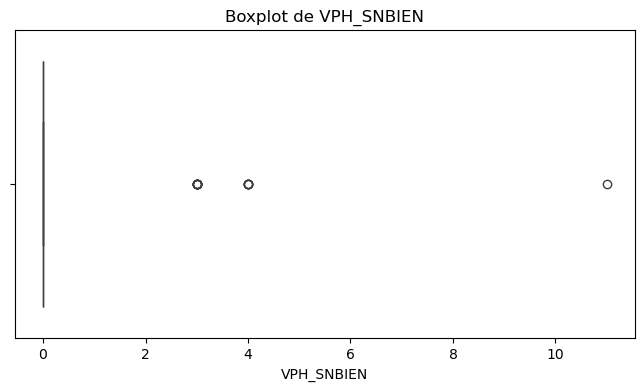

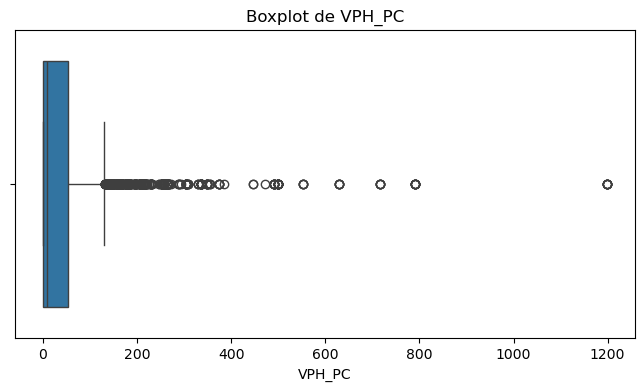

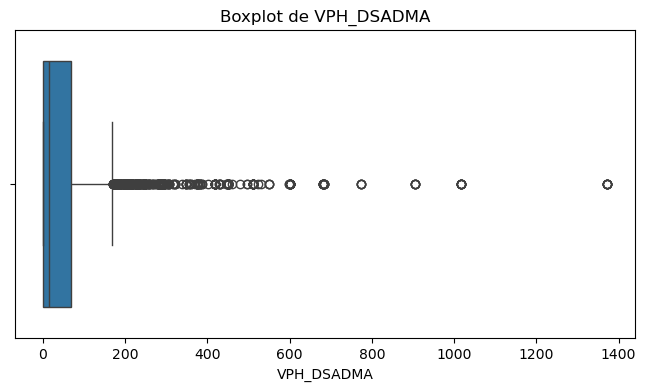

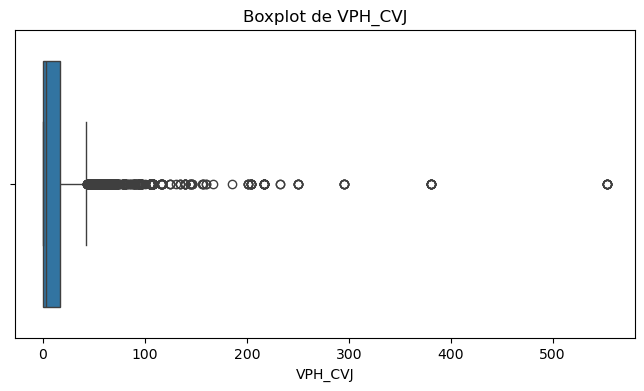

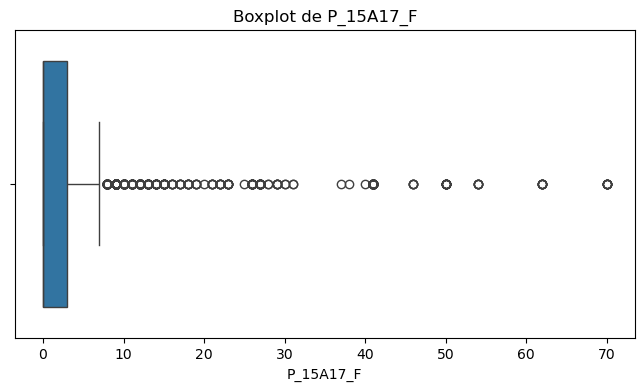

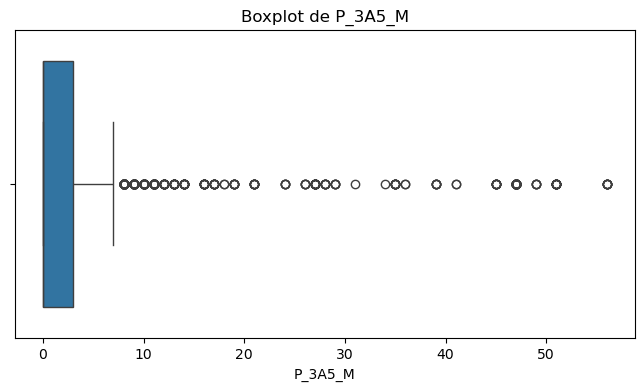

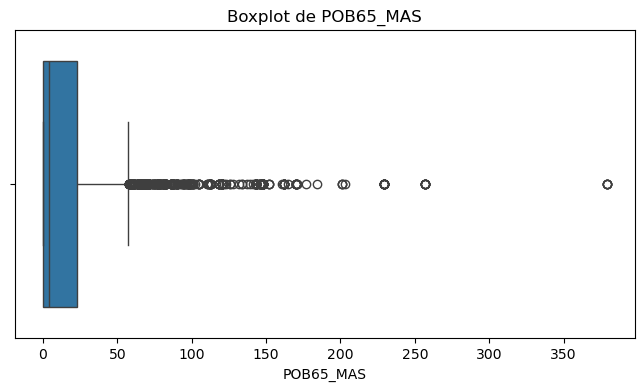

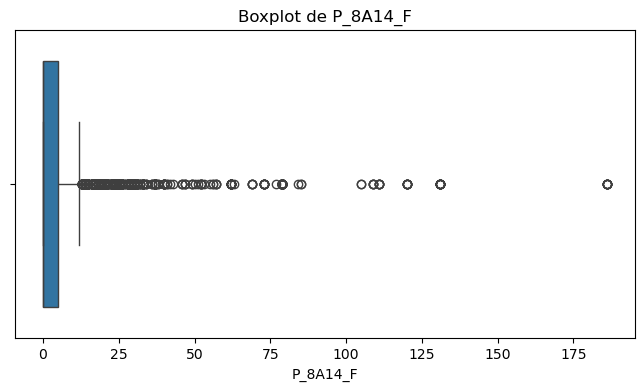

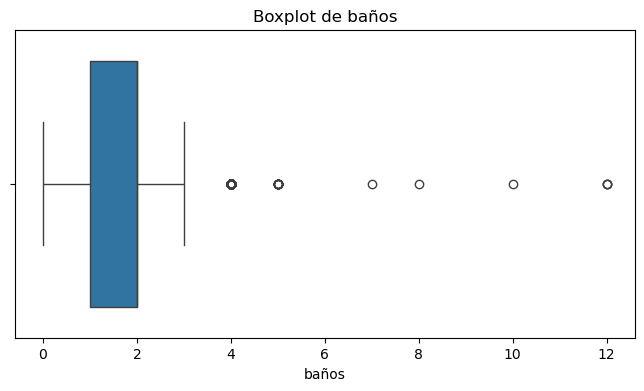

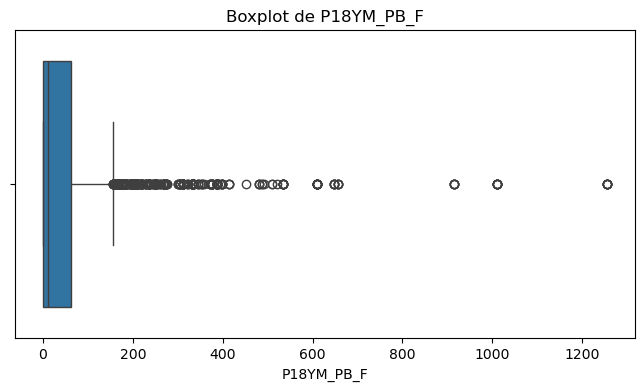

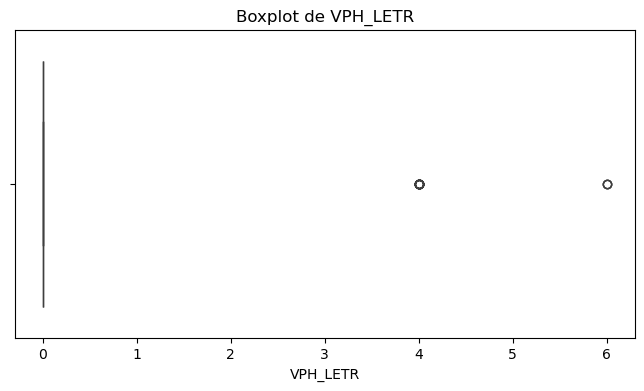

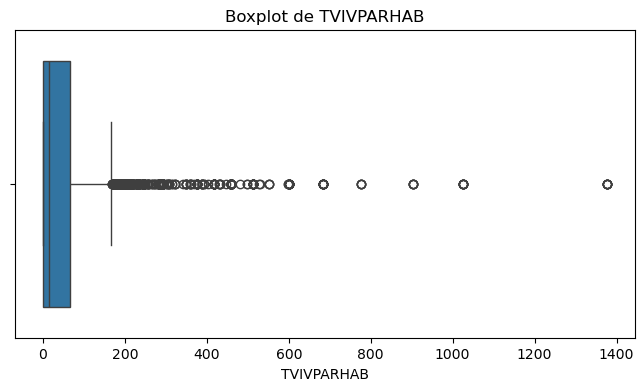

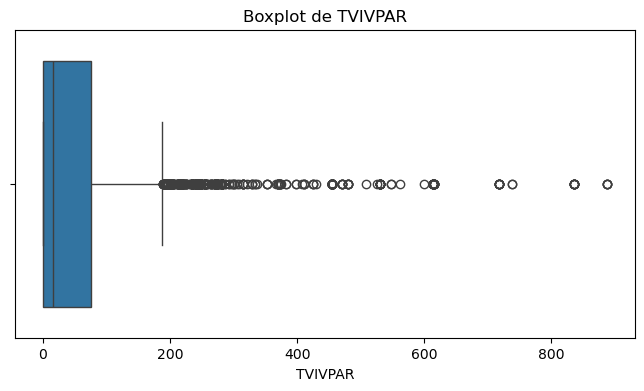

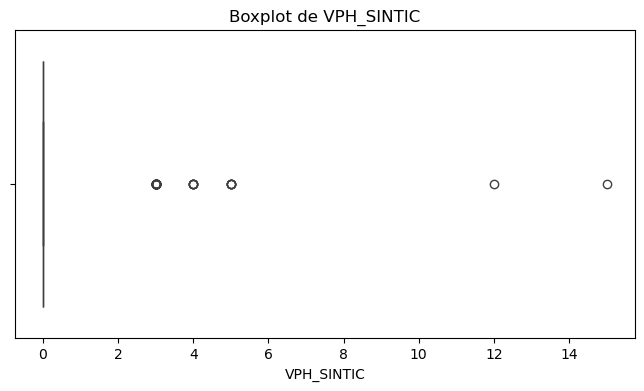

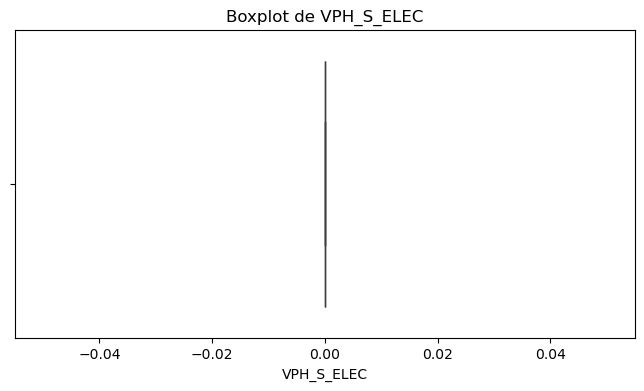

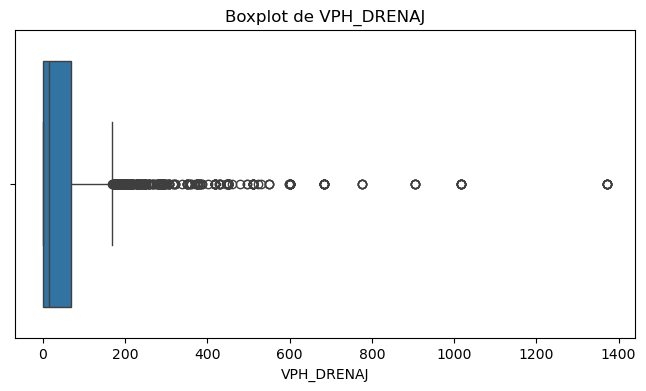

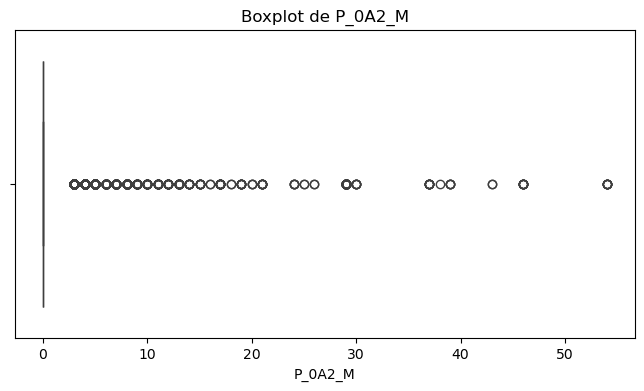

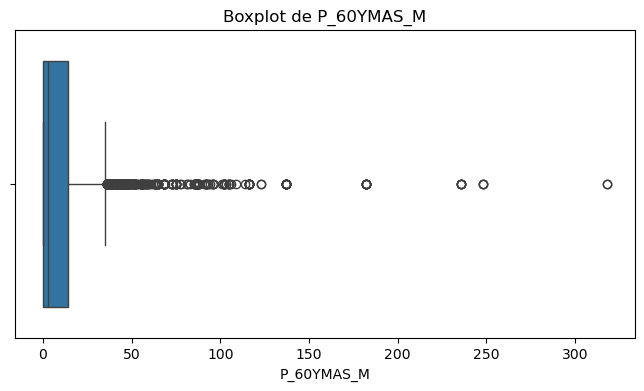

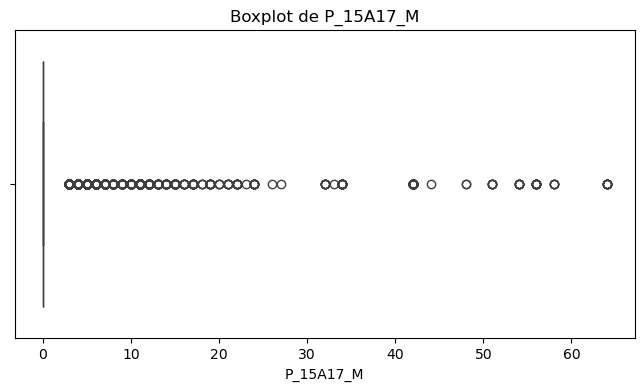

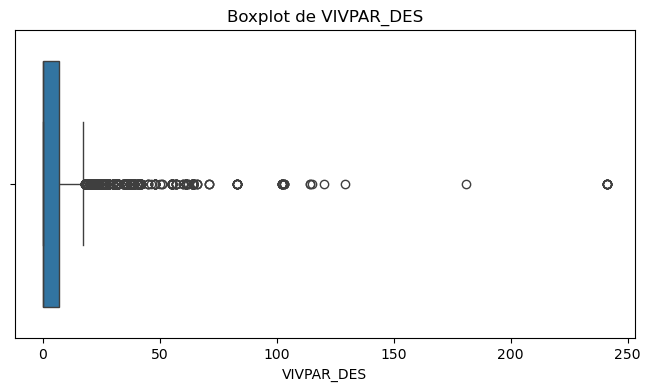

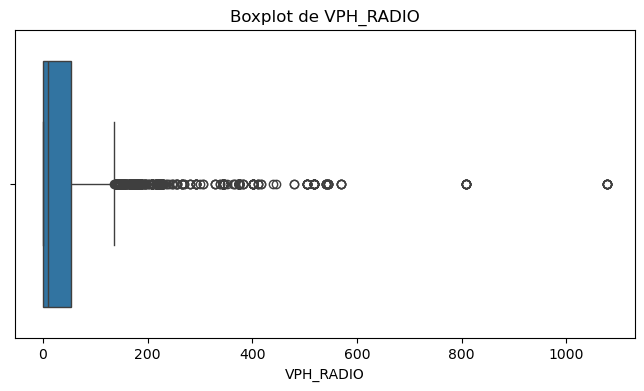

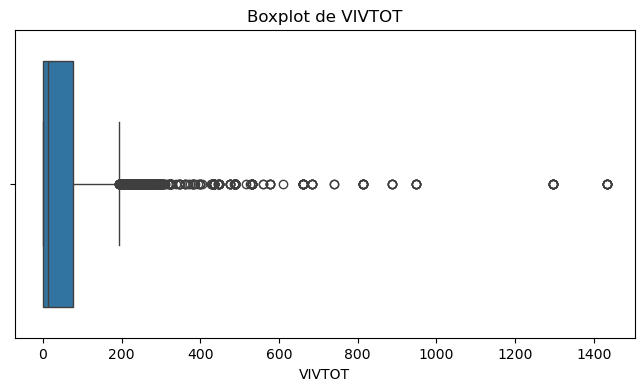

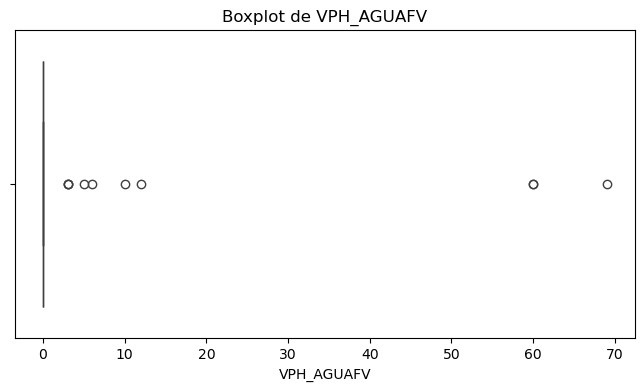

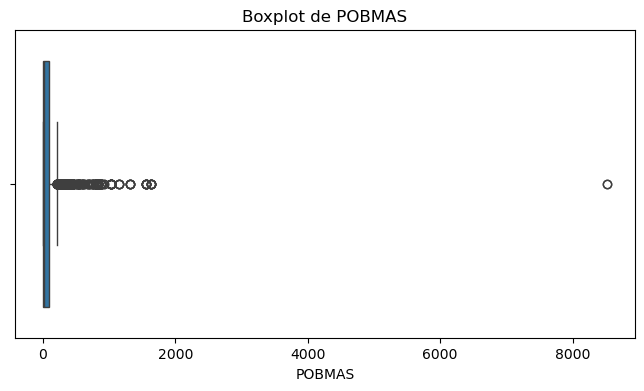

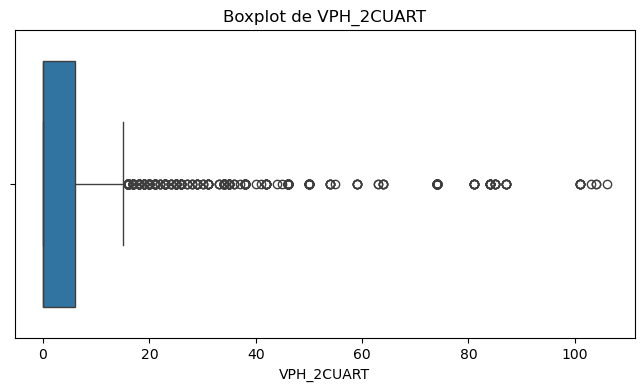

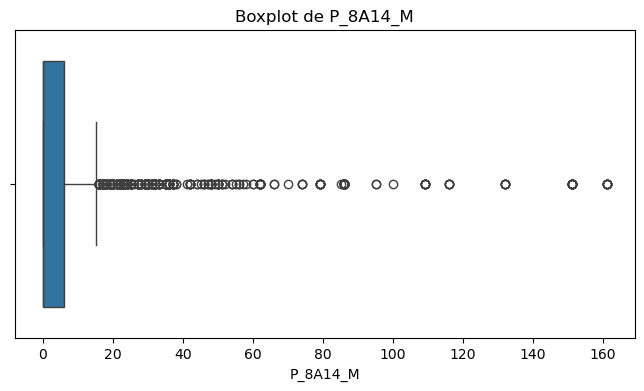

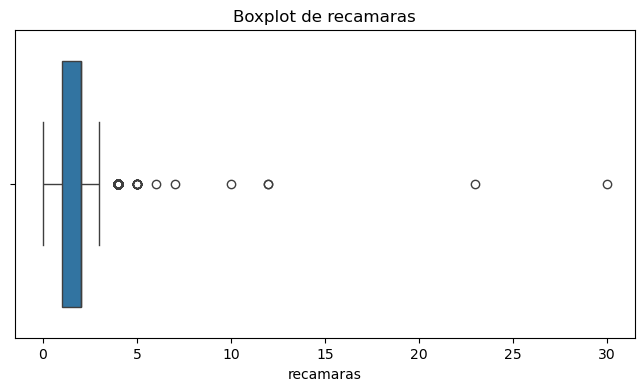

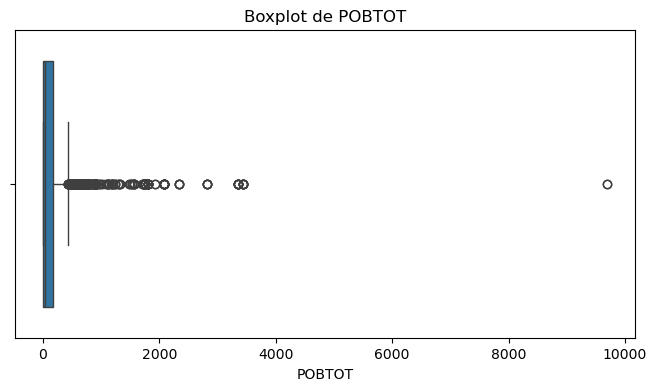

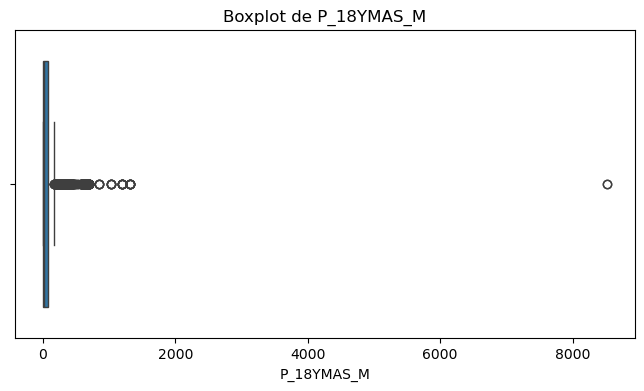

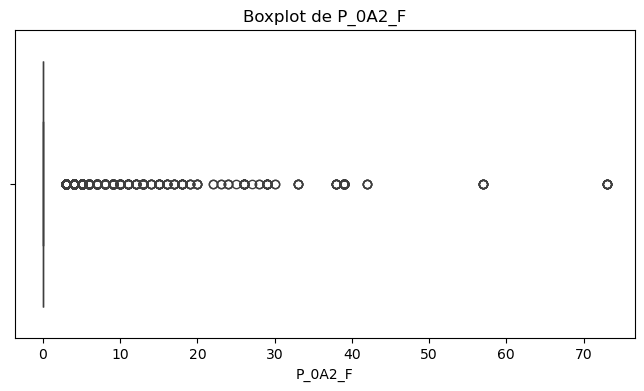

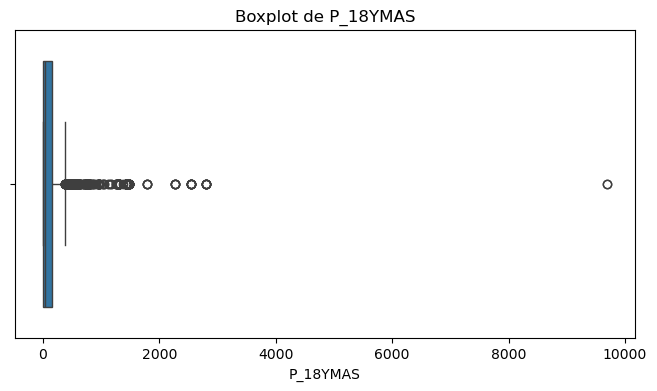

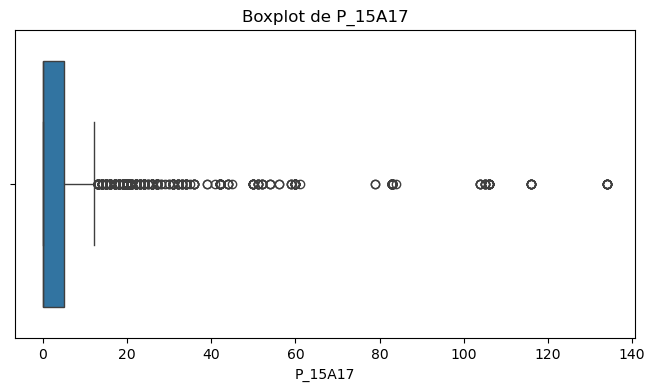

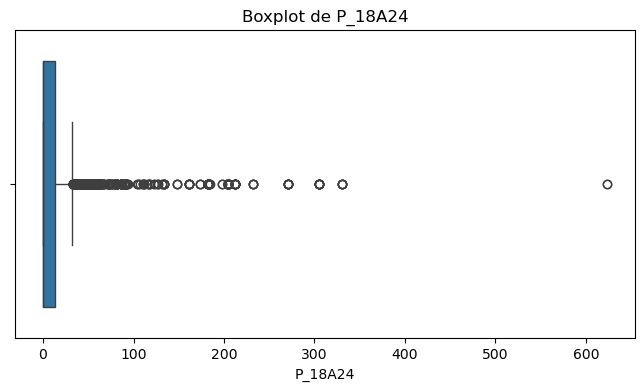

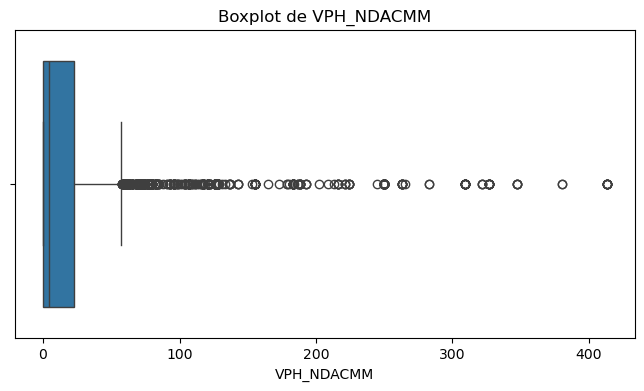

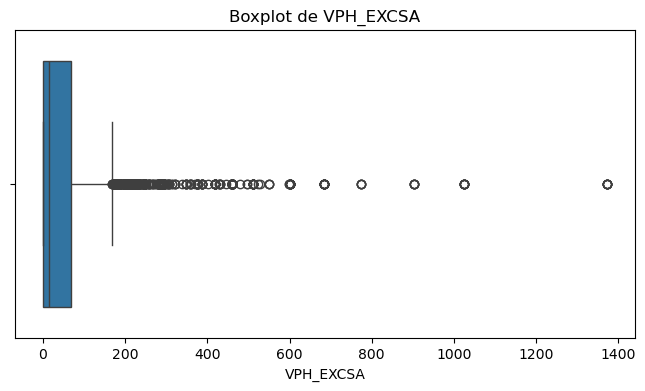

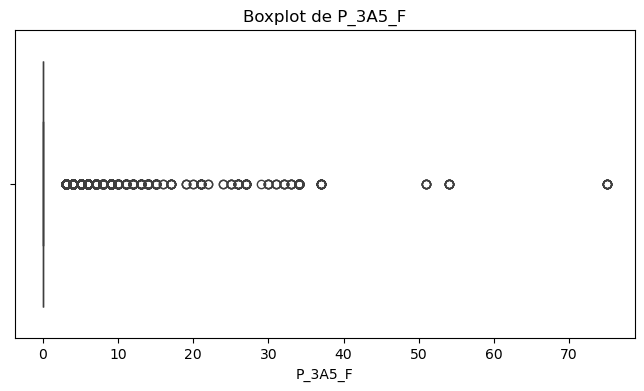

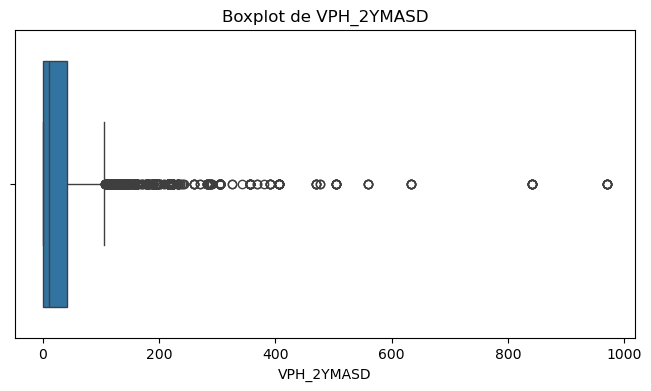

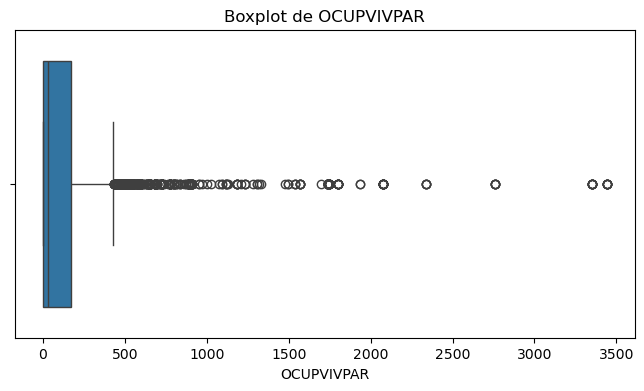

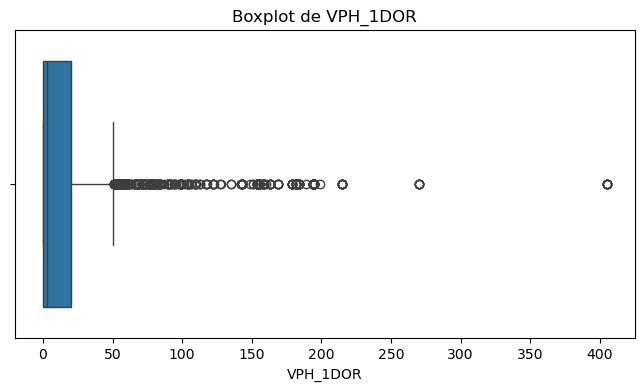

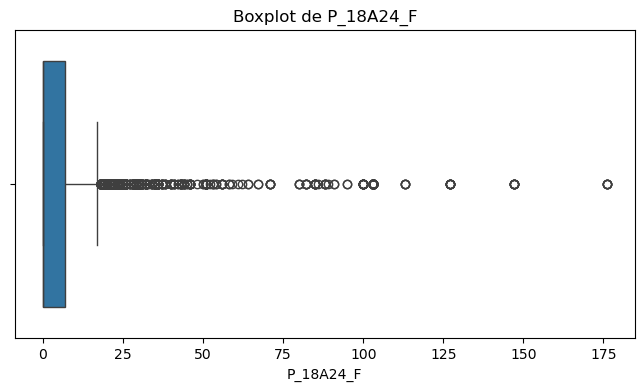

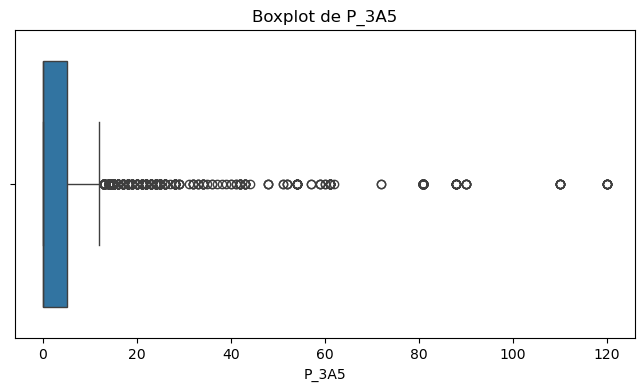

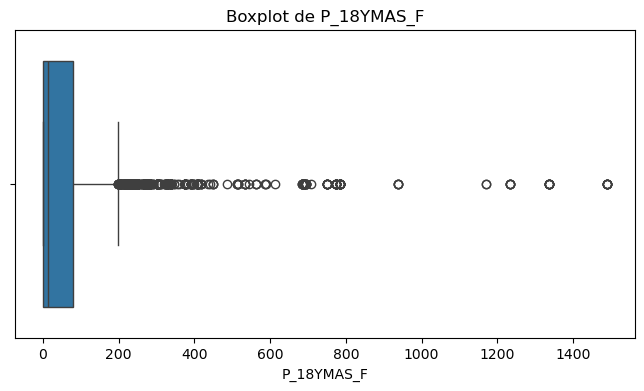

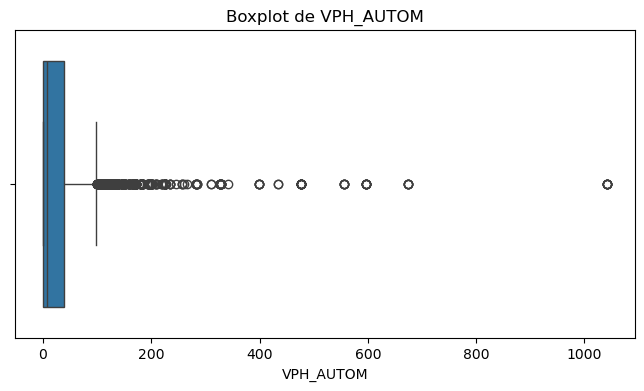

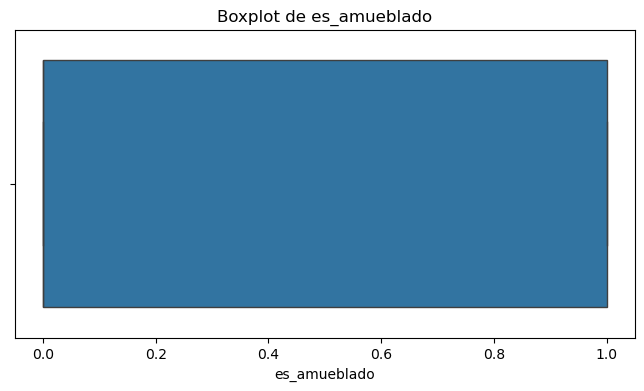

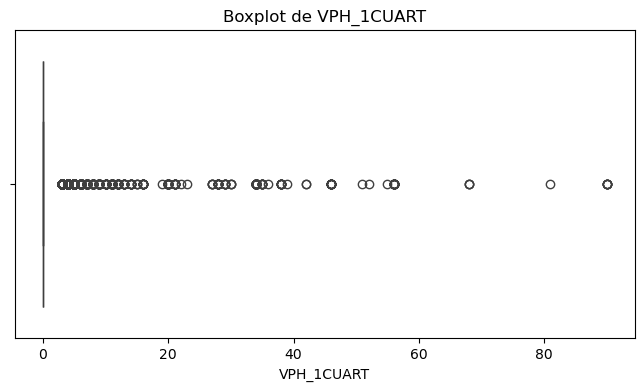

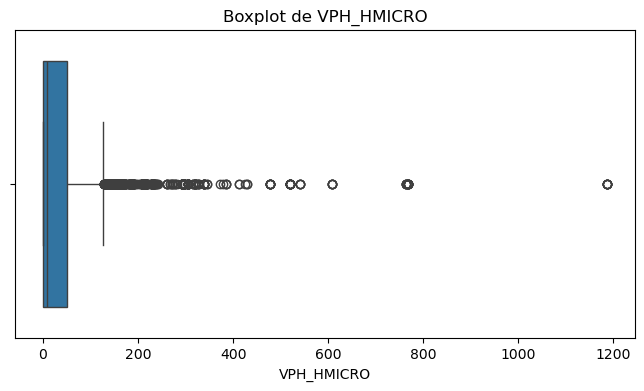

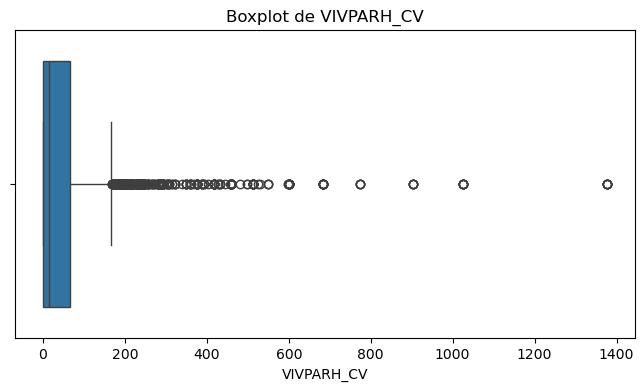

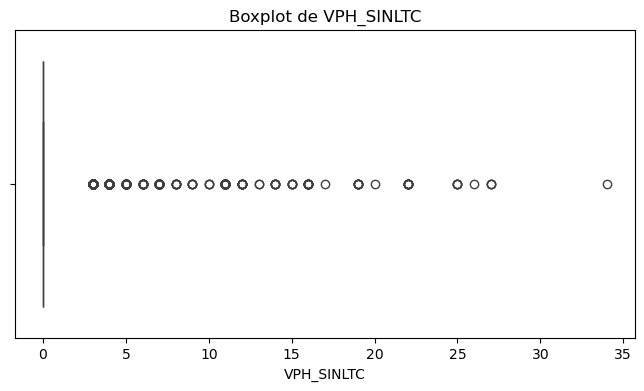

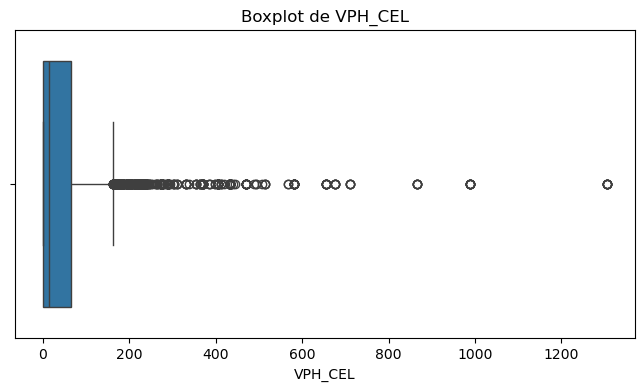

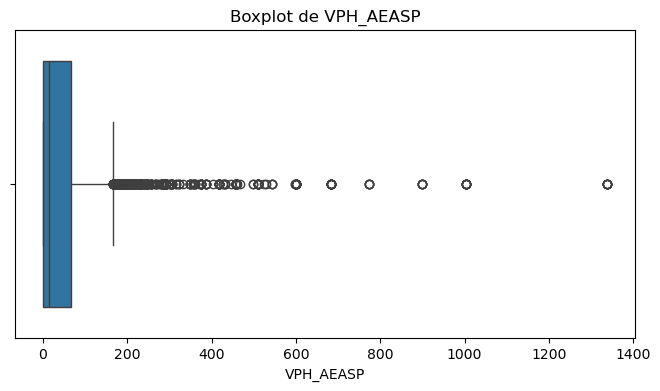

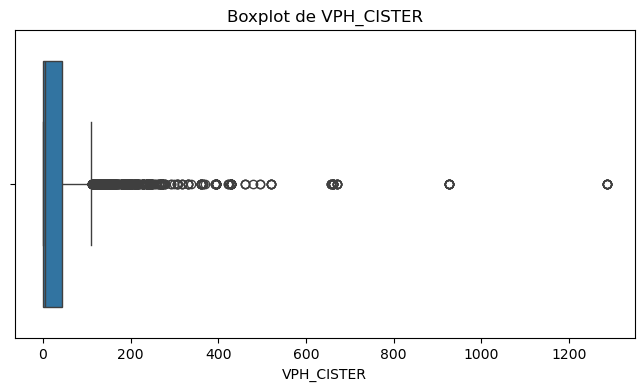

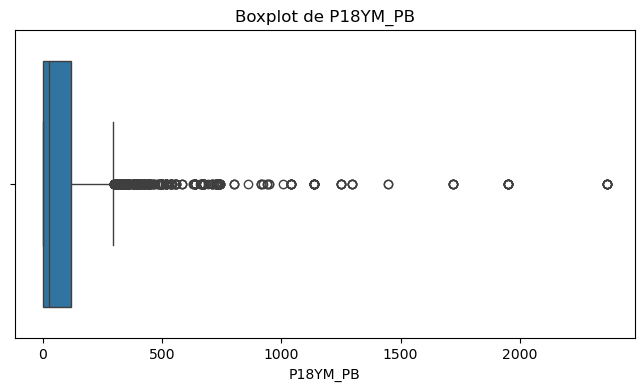

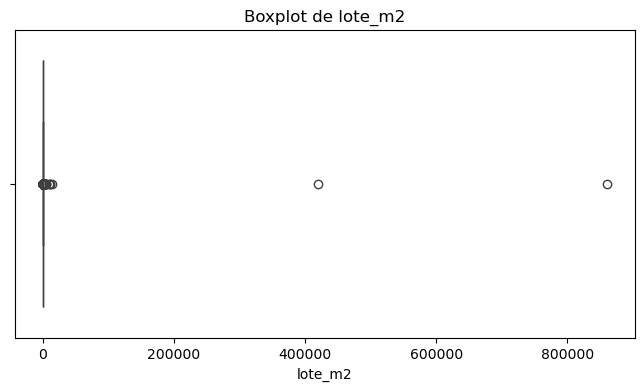

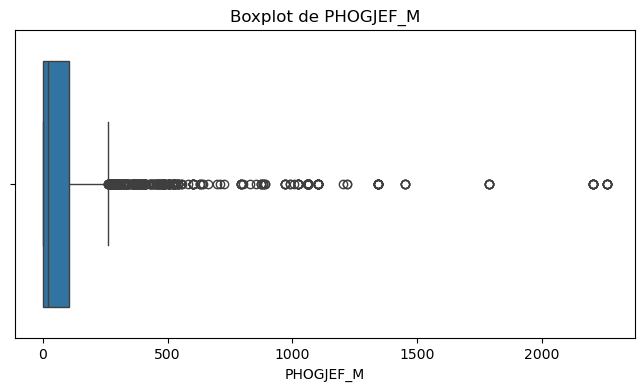

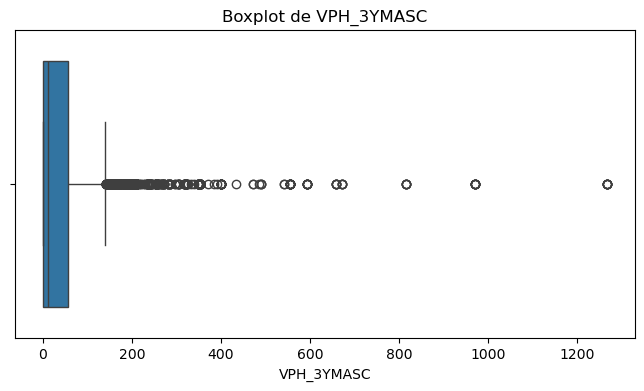

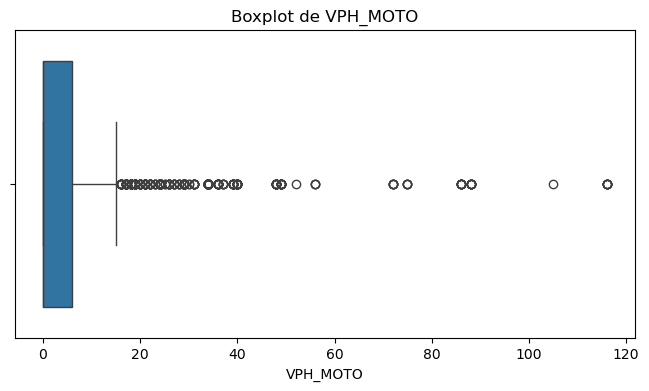

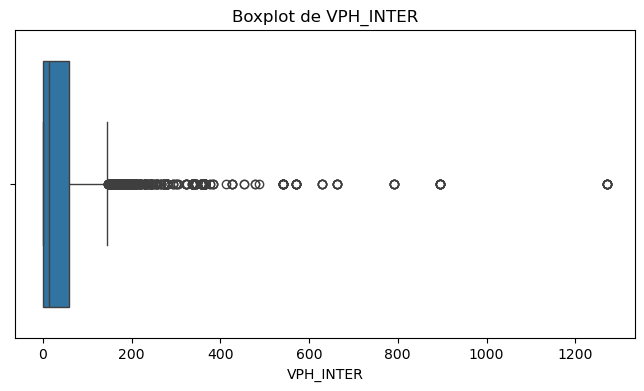

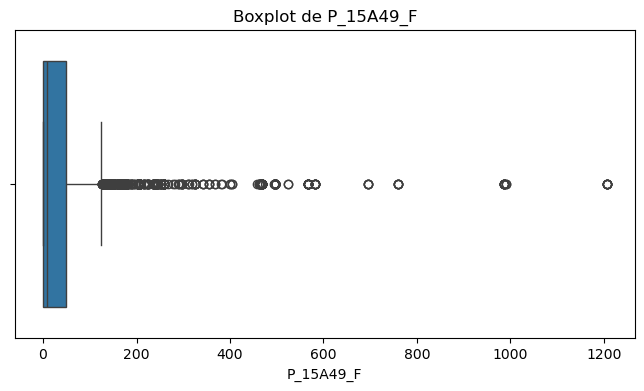

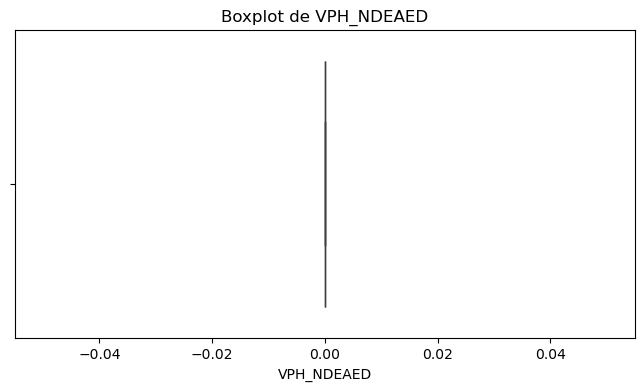

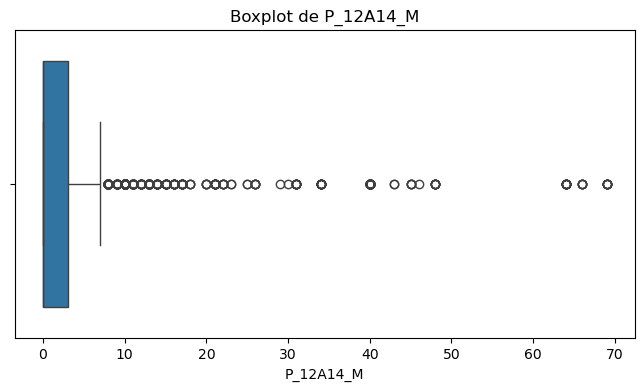

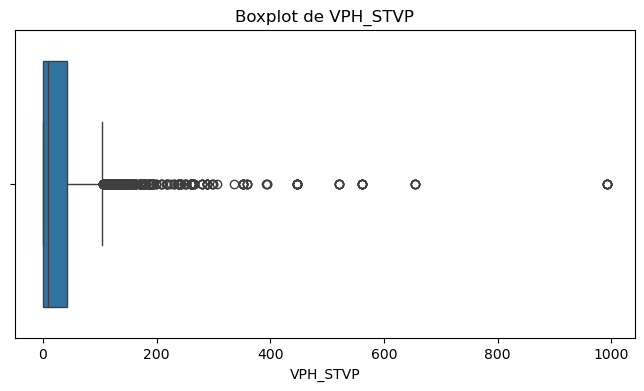

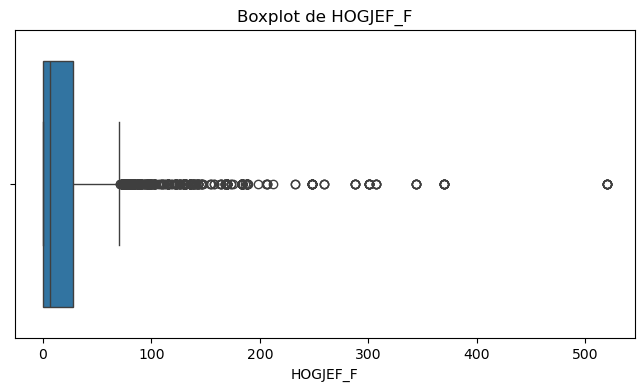

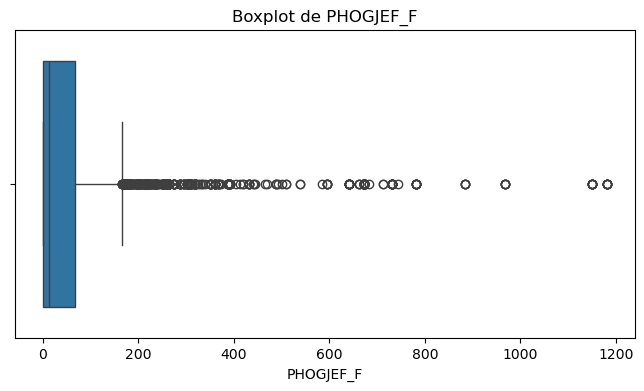

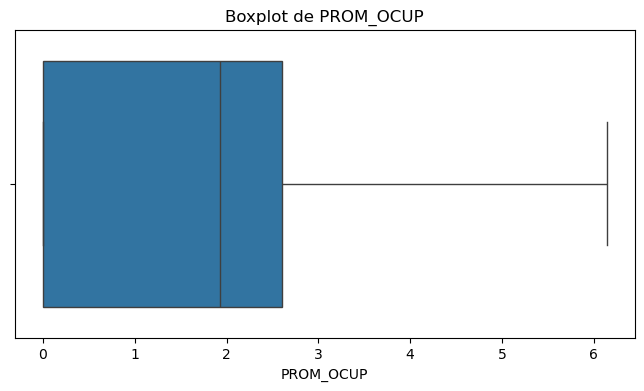

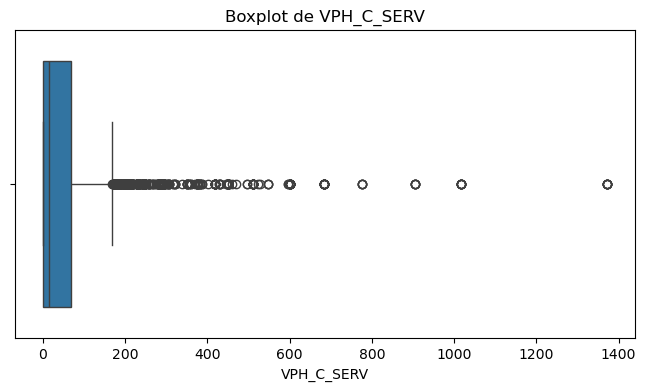

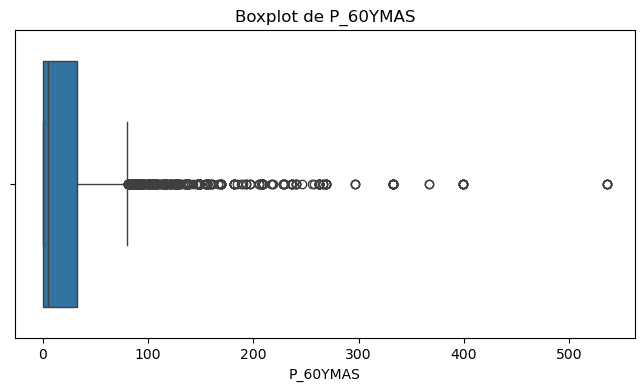

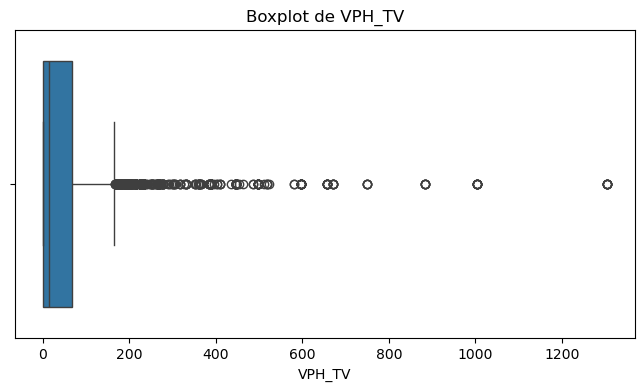

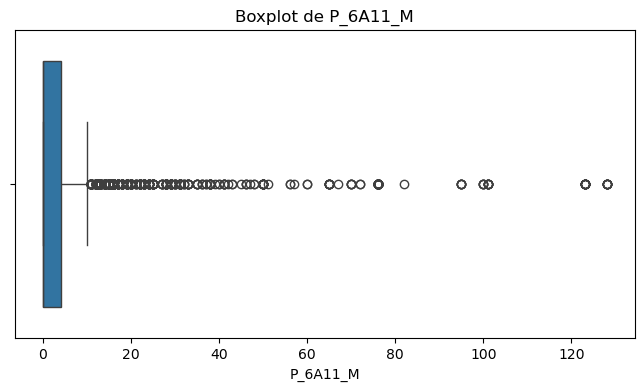

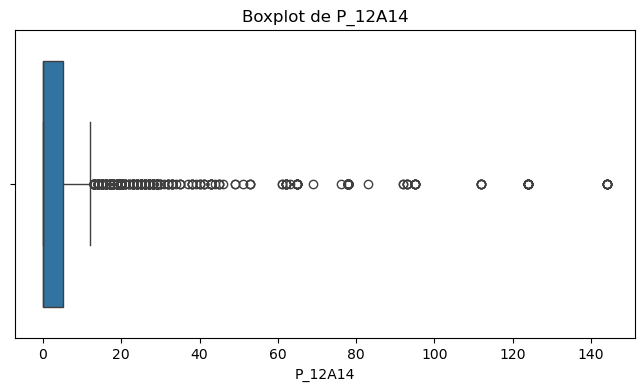

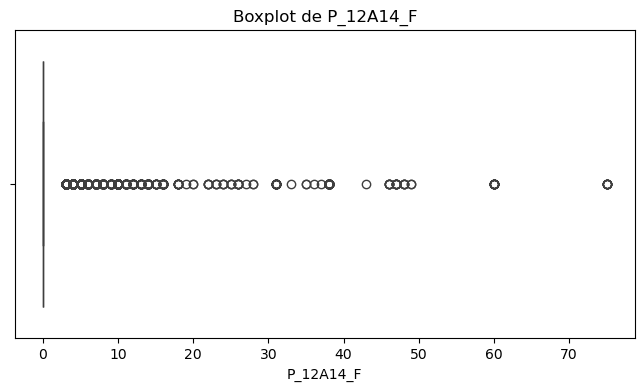

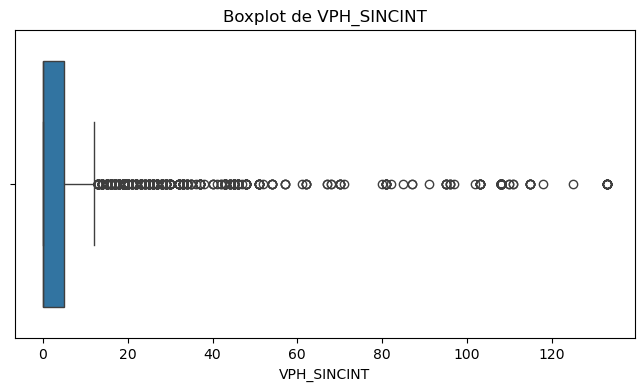

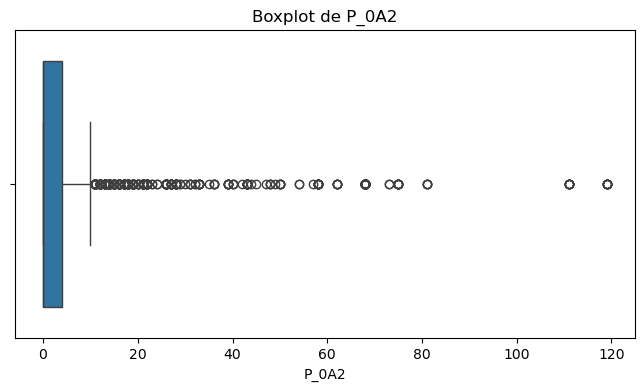

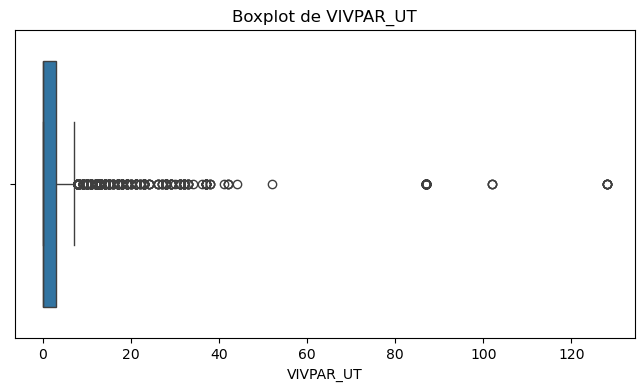

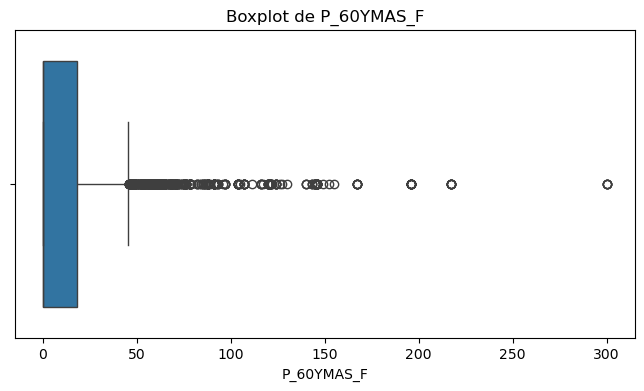

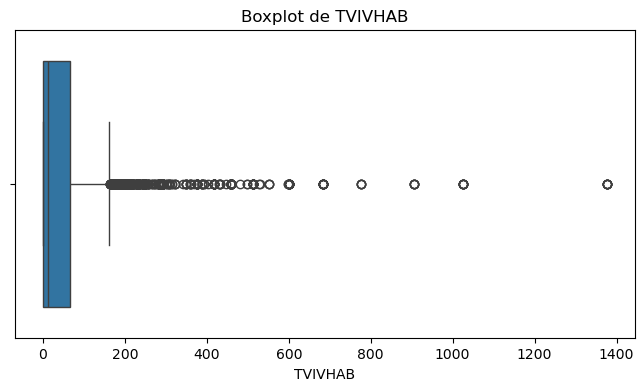

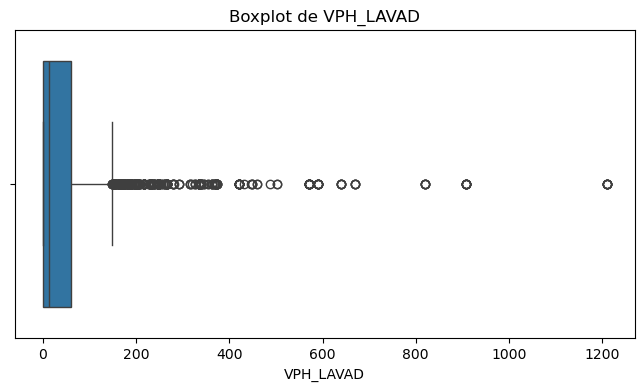

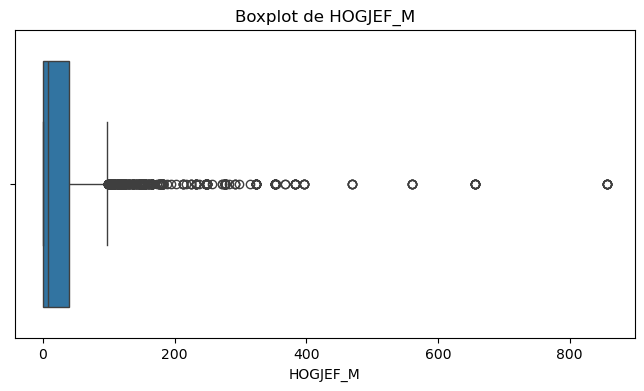

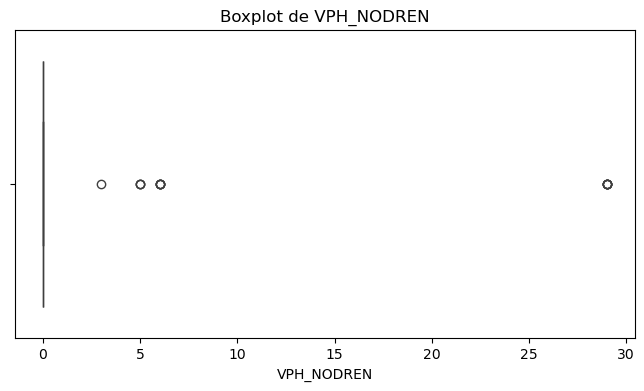

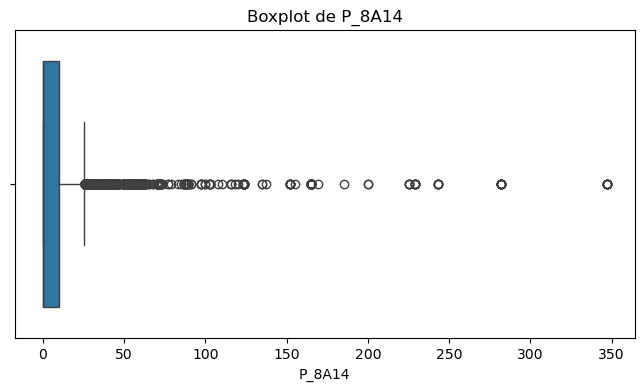

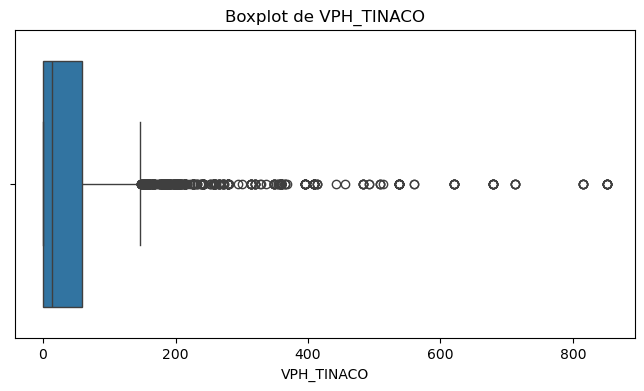

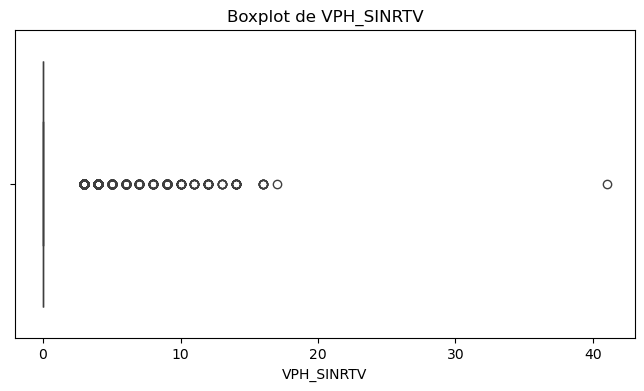

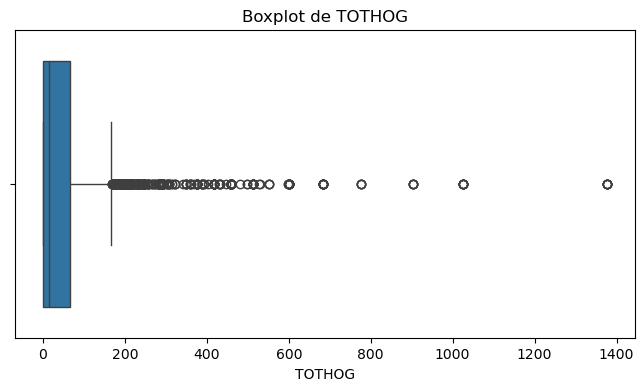

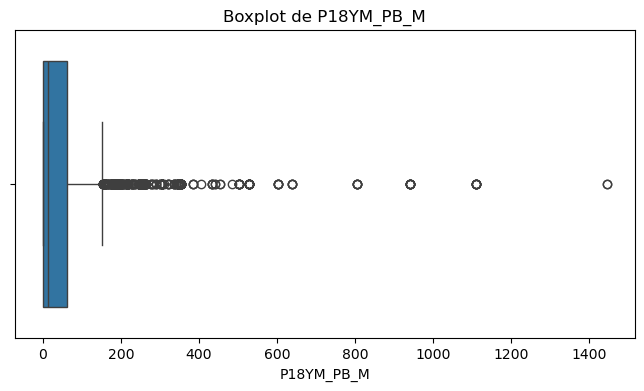

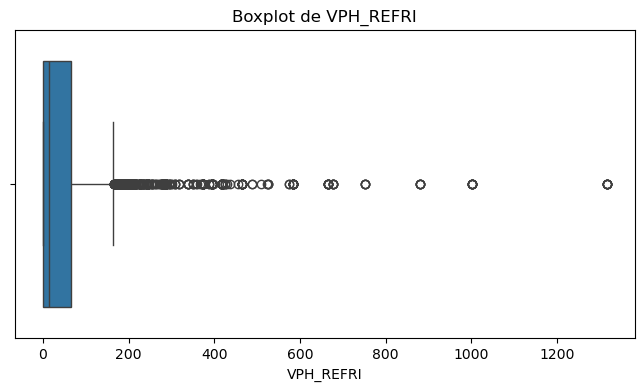

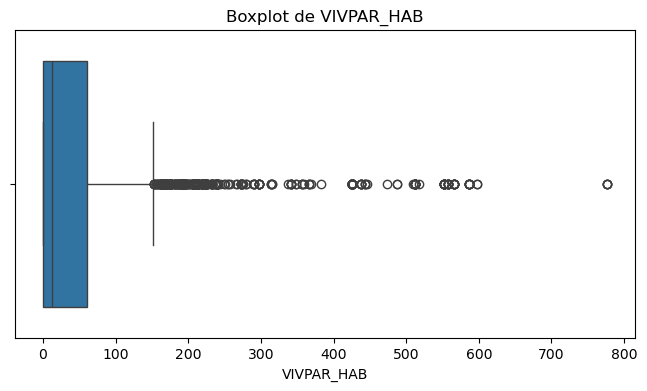

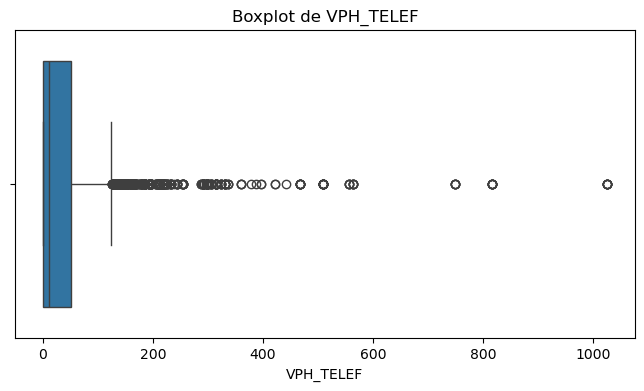

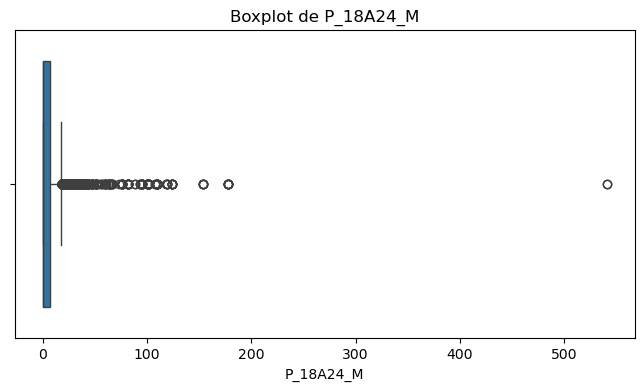

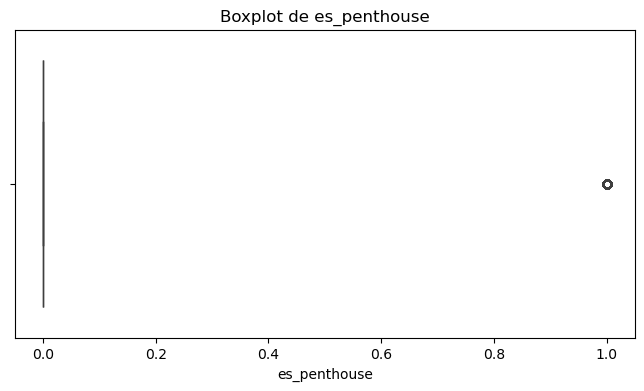

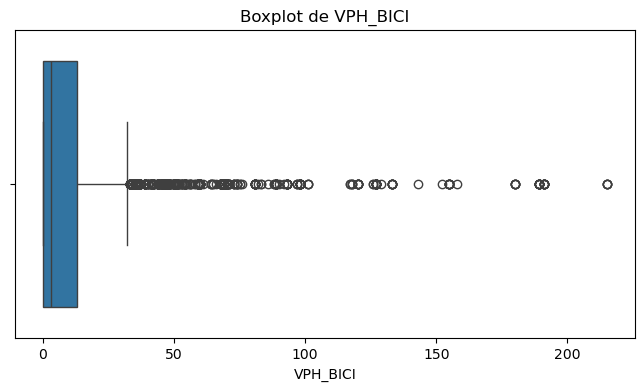

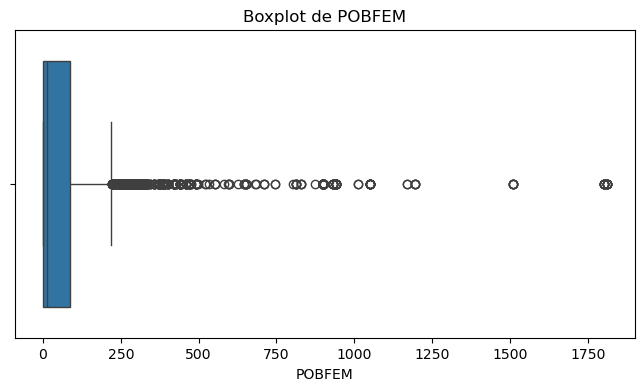

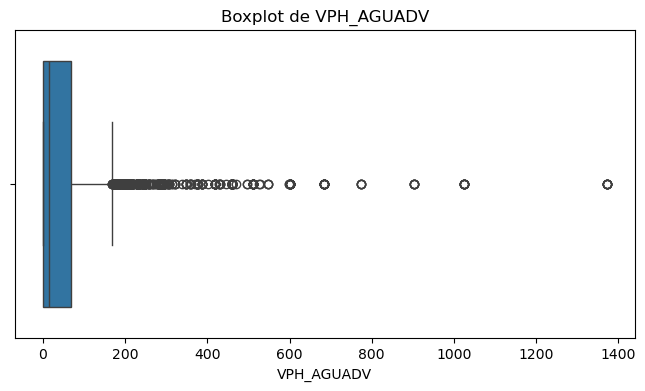

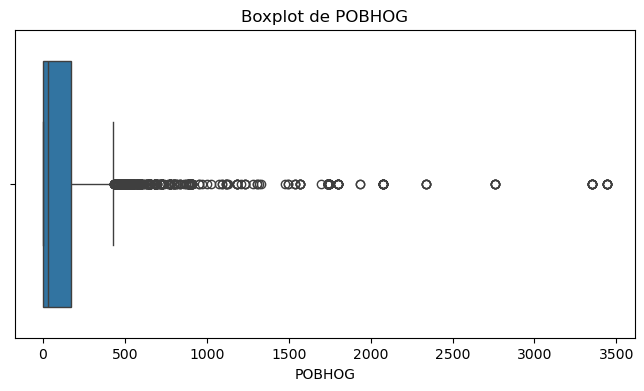

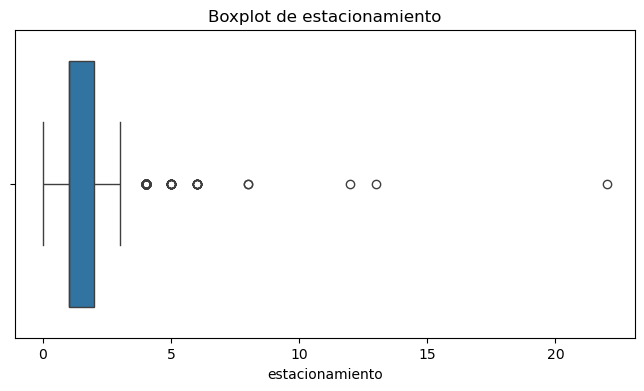

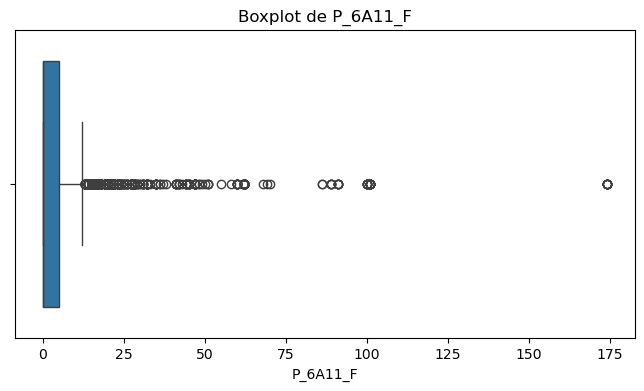

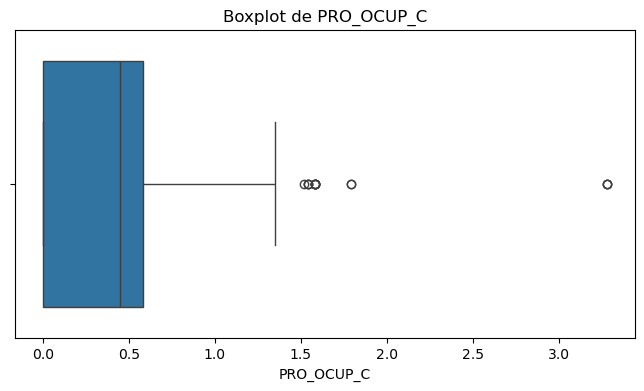

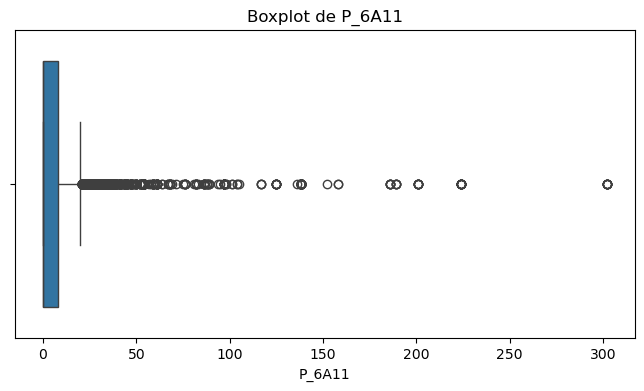

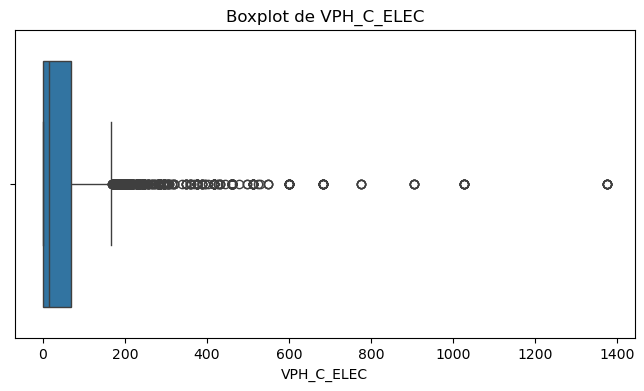

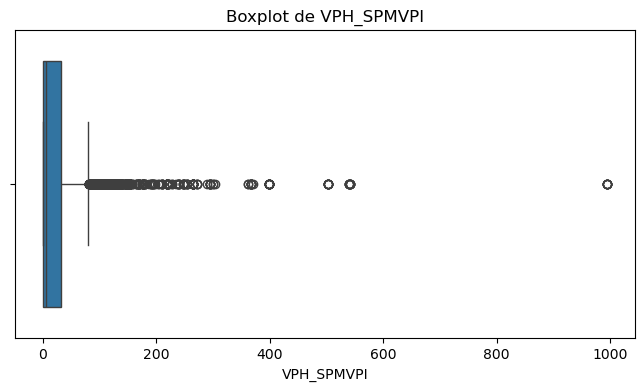

In [51]:
# Aplicar la función a las columnas numéricas
for col in numeric_cols:
    outliers = detectar_outliers_iqr(df, col)
    print(f"\nNúmero de outliers en {col}: {len(outliers)}")
    if len(outliers) > 0:
        print(outliers[[col]].head())
    # Visualizar outliers
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot de {col}")  

identificamos 2 outliers evidentes y muy seprados del resto de los datos en lote_m2, los cuales eliminamos

In [52]:
df.sort_values('lote_m2', ascending=False).head(10)

precio_mxn  lote_m2  recamaras  baños  estacionamiento  es_amueblado  \
3212      26000.0   860000        2.0    2.0              2.0             1   
20259     19000.0   420000        1.0    1.0              1.0             0   
1510      20000.0    13000        2.0    2.0              1.0             0   
3737      37000.0    10000        2.0    2.0              2.0             0   
3713      30000.0     9974        1.0    1.0              0.0             0   
20829     32500.0     9140        2.0    2.0              1.0             0   
915       49000.0     5000        3.0    3.0              2.0             0   
12        37000.0     5000        3.0    2.0              2.0             0   
14018     10400.0     4000        2.0    2.0              1.0             0   
9810      33000.0     3000        1.0    1.0              2.0             1   

       es_penthouse                                          direccion  \
3212              0               revillagigedo 18 centro   cuauhtemoc   
20259             0  alvaro obregon  guadalupe inn guadalupe inn  a...   
1510              0      av. victor hugo portales norte  benito juarez   
3737              0  lago andromaco ampliacion granada  miguel hidalgo   
3713              0             rio churubusco 601 xoco  benito juarez   
20829             0  avenida benjamin franklin hipodromo condesa  c...   
915               0  cumbres de santa fe santa fe cuajimalpa  cuaji...   
12                0  loma de la palma 29 lomas de vista hermosa  cu...   
14018             0  prolongacion ocote san jose de los cedros  cua...   
9810              0     av tecamachalco reforma social  miguel hidalgo   

              colonia    cp  ...                        road quarter  \
3212       cuauhtemoc  6500  ...  Avenida Insurgentes Centro    None   
20259   guadalupe inn  1020  ...          Avenida Revolución    None   
1510   portales norte  3303  ...         Avenida Víctor Hugo    None   
3737          hidalgo  1120  ...                  Calle Tula    None   
3713             xoco  3330  ...         Avenida Universidad    None   
20829       hipodromo  6100  ...   Avenida Benjamín Franklin    None   
915          santa fe  1210  ...         Avenida Carlos Lazo    None   
12         cuajimalpa  5000  ...              Avenida México    None   
14018      los cedros  1510  ...               Calle Casitas    None   
9810          hidalgo  1120  ...                Calle Bejuco    None   

                     borough  postcode  longitud_1  latitud_1   neighbourhood  \
3212              Cuauhtémoc     06500  -99.159289  19.432015      cuauhtemoc   
20259         Álvaro Obregón     01040  -99.190509  19.351696   guadalupe inn   
1510           Benito Juárez     03303  -99.148644  19.370439  portales norte   
3737          Álvaro Obregón     01120  -99.206255  19.400896         hidalgo   
3713           Benito Juárez     03330  -99.170877  19.360889            xoco   
20829             Cuauhtémoc     06100  -99.179713  19.406483       hipodromo   
915           Álvaro Obregón     01376  -99.263476  19.362460        santa fe   
12     Cuajimalpa de Morelos     05000  -99.299234  19.367031      cuajimalpa   
14018         Álvaro Obregón     01377  -99.243126  19.368324      los cedros   
9810          Álvaro Obregón     01120  -99.208977  19.400287         hidalgo   

      distancia                                        source_file  \
3212   0.013051  merged_inmuebles24_departamentos_duckdb_2025-1...   
20259  0.000689  merged_inmuebles24_departamentos_duckdb_2025-1...   
1510   0.000350  merged_inmuebles24_departamentos_duckdb_2025-1...   
3737   0.042794  merged_inmuebles24_departamentos_duckdb_2025-1...   
3713   0.002160  merged_inmuebles24_departamentos_duckdb_2025-1...   
20829  0.001404  merged_inmuebles24_departamentos_duckdb_2025-1...   
915    0.014988  merged_inmuebles24_departamentos_duckdb_2025-1...   
12     0.021311  merged_inmuebles24_departamentos_duckdb_2025-1...   
14018  

In [53]:
# Identificar los índices de los dos outliers más grandes
outliers = df.sort_values('lote_m2', ascending=False).head(2).index

In [54]:
# Eliminar los outliers del DataFrame
df = df.drop(outliers)


In [55]:
categorical_columns = list(df.select_dtypes(include=["object", "category"]).columns)
categorical_columns.remove('direccion')

In [56]:
df = pd.get_dummies(df, columns=['municipio','colonia_top10'], drop_first=True)

In [57]:
df.head()

precio_mxn  lote_m2  recamaras  baños  estacionamiento  es_amueblado  \
0     18000.0      130        2.0    1.0              1.0             0   
1     30000.0      198        2.0    2.0              2.0             0   
2     23500.0      110        2.0    2.0              1.0             1   
3     14000.0       59        2.0    1.0              1.0             0   
4     14000.0       30        1.0    1.0              1.0             1   

   es_penthouse                                          direccion  \
0             0         rio becerra 135 8 de agosto  benito juarez   
1             0     avenida rio mixcoac 206 acacias  benito juarez   
2             0  av. san francisco  col. del valle actipan  ben...   
3             0              calle 2 agricola pantitlan  iztacalco   
4             0  av. tamaulipas 257 alvaro obregon  ciudad de m...   

              colonia    cp  ... colonia_top10_cuajimalpa  \
0         8 de agosto  1180  ...                    False   
1             acacias  3240  ...                    False   
2             actipan  3230  ...                    False   
3  agricola pantitlan  8100  ...                    False   
4      alvaro obregon  9230  ...                    False   

  colonia_top10_cuauhtemoc  colonia_top10_del valle centro  \
0                    False                           False   
1                    False                           False   
2                    False                           False   
3                    False                           False   
4                    False                           False   

   colonia_top10_hidalgo colonia_top10_hipodromo colonia_top10_napoles  \
0                  False                   False                 False   
1                  False                   False                 False   
2                  False                   False                 False   
3                  False                   False                 False   
4                  False                   False                 False   

  colonia_top10_narvarte poniente colonia_top10_otros colonia_top10_santa fe  \
0                           False                True                  False   
1                           False                True                  False   
2                           False                True                  False   
3                           False                True                  False   
4                           False                True                  False   

  colonia_top10_xoco  
0              False  
1              False  
2              False  
3              False  
4              False  

[5 rows x 178 columns]

In [58]:
df.shape

(8289, 178)

# Clustering
Realiza un análisis de clustering para agrupar los datos en diferentes segmentos.

In [59]:
df_analysis = df[numeric_cols].copy()

In [60]:
#df_analysis['random'] = np.random.rand(len(df_analysis))

In [61]:
cols = df_analysis.columns

In [62]:
# Escalar los datos
scaler = StandardScaler()
df_analysis[cols] = scaler.fit_transform(df_analysis[cols])

In [63]:
## Arreglar los nulos y quitar esta celda
df_analysis = df_analysis.dropna()

In [64]:
df_analysis.dtypes[120:]

Series([], dtype: object)

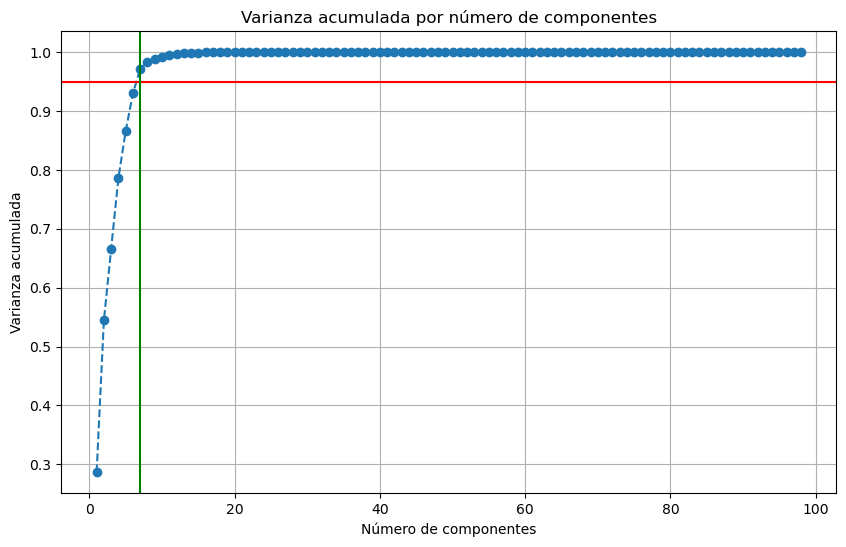

Número óptimo de componentes: 7


In [65]:
# Crear el modelo PCA sin especificar n_components
pca = PCA()
pca.fit(df_analysis)

# Calcular la varianza acumulada
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

#Gráfica de la varianza acumulada
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Varianza acumulada por número de componentes')
plt.xlabel('Número de componentes')
plt.ylabel('Varianza acumulada')
plt.axhline(y=0.95, color='r', linestyle='-')
plt.axvline(x=np.argmax(cumulative_variance >= 0.95) + 1, color='g', linestyle='-')
plt.grid()
plt.show()

# Elegir el número de componentes que expliquen al menos el 95% de la varianza
n_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Número óptimo de componentes: {n_components}")



In [66]:
print("Varianza acumulada:")
print(cumulative_variance)


Varianza acumulada:
[0.28661335 0.5444166  0.66634704 0.78652793 0.86617808 0.93019219
 0.97178877 0.98324476 0.98837729 0.99219196 0.99548471 0.99713228
 0.99852012 0.99894265 0.9993001  0.99964318 0.99990797 0.99999426
 0.99999869 0.99999943 0.99999974 0.99999993 0.99999997 1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         

In [67]:
# Aplicar PCA con el número óptimo de componentes
pca = PCA(n_components=n_components)
pca_data = pca.fit_transform(df_analysis)

In [68]:
# Importancia de cada componente (varianza explicada)
explained_variance = pca.explained_variance_ratio_
print("Varianza explicada por cada componente:")
for i, var in enumerate(explained_variance):
    print(f"Componente {i+1}: {var:.2%}")

Varianza explicada por cada componente:
Componente 1: 28.66%
Componente 2: 25.78%
Componente 3: 12.19%
Componente 4: 12.02%
Componente 5: 7.97%
Componente 6: 6.40%
Componente 7: 4.16%


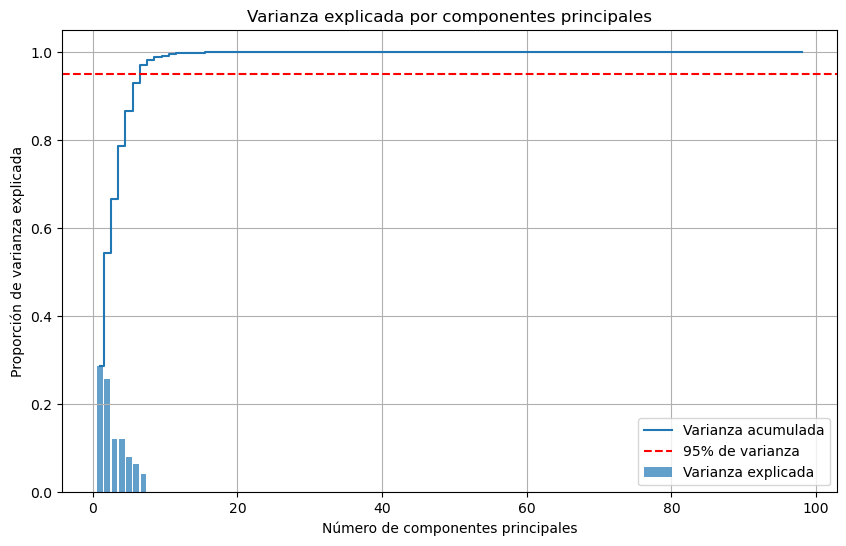

In [69]:
# Gráfica de varianza explicada por cada componente
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, label='Varianza explicada')
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Varianza acumulada')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% de varianza')
plt.xlabel('Número de componentes principales')
plt.ylabel('Proporción de varianza explicada')
plt.title('Varianza explicada por componentes principales')
plt.legend(loc='best')
plt.grid()
plt.show()

In [70]:
# Contribución de las características originales a los primeros 22 componentes
components = pd.DataFrame(pca.components_[:20], columns=df_analysis.columns)
print("\nContribución de las características originales a los primeros 22 componentes:")
components.T.sort_values(by = 0, ascending=False)


Contribución de las características originales a los primeros 22 componentes:


0         1         2         3         4         5  \
baños            0.509141  0.231675 -0.032140 -0.118081  0.040596 -0.041512   
recamaras        0.503033  0.266494 -0.023495 -0.263238 -0.669055 -0.037264   
estacionamiento  0.450470  0.206260  0.011949 -0.100799  0.713381 -0.271181   
es_penthouse     0.229651  0.108722  0.483232  0.828989 -0.105095 -0.051018   
lote_m2          0.182074  0.081962  0.028148 -0.000506  0.171794  0.959538   
...                   ...       ...       ...       ...       ...       ...   
VIVPAR_HAB      -0.064181  0.133270  0.003312 -0.001110  0.003366  0.000363   
VPH_SINRTV      -0.065295  0.136594  0.005088 -0.001995  0.005708  0.000591   
VPH_NDACMM      -0.067968  0.141902  0.003509 -0.001191  0.003543  0.000668   
VPH_BICI        -0.077987  0.161848  0.004438 -0.000775  0.005918  0.001439   
es_amueblado    -0.096682 -0.070762  0.873789 -0.468330  0.025805 -0.001594   

                        6  
baños            0.817676  
recamaras       -0.396218  
estacionamiento -0.402161  
es_penthouse    -0.032463  
lote_m2         -0.095390  
...                   ...  
VIVPAR_HAB       0.002304  
VPH_SINRTV       0.008410  
VPH_NDACMM       0.004182  
VPH_BICI         0.009435  
es_amueblado     0.045592  

[98 rows x 7 columns]

In [71]:
most_important_features = components.iloc[0].abs().sort_values(ascending=False).head(35)
print("Características más importantes del primer componente:")
print(most_important_features)

Características más importantes del primer componente:
baños              0.509141
recamaras          0.503033
estacionamiento    0.450470
es_penthouse       0.229651
lote_m2            0.182074
es_amueblado       0.096682
VPH_BICI           0.077987
VPH_NDACMM         0.067968
VPH_SINRTV         0.065295
VIVPAR_HAB         0.064181
TVIVPAR            0.061619
VPH_TINACO         0.058894
HOGJEF_F           0.058397
VPH_1DOR           0.057680
PHOGJEF_F          0.055147
VPH_MOTO           0.054924
P_60YMAS_F         0.054142
VPH_REFRI          0.053388
TVIVHAB            0.053064
VPH_AEASP          0.052954
VPH_CISTER         0.052864
VPH_C_SERV         0.052849
VPH_DRENAJ         0.052833
VPH_DSADMA         0.052798
VPH_AGUADV         0.052660
VPH_CEL            0.052628
VPH_EXCSA          0.052625
VPH_C_ELEC         0.052605
TOTHOG             0.052597
TVIVPARHAB         0.052597
VIVPARH_CV         0.052596
VIVTOT             0.052453
VPH_TV             0.052218
VPH_3YMASC         0.

In [72]:
# Reconstrucción aproximada de los datos originales
reconstructed_data = pca.inverse_transform(pca_data)

In [73]:

# Comparar los datos originales con los reconstruidos
print("Datos originales (primeras filas):")
df_analysis.head()

Datos originales (primeras filas):


VPH_SNBIEN    VPH_PC  VPH_DSADMA   VPH_CVJ  P_15A17_F   P_3A5_M  \
0    -0.038975 -0.496554   -0.495561 -0.442537   -0.35384 -0.357182   
6    -0.038975 -0.496554   -0.495561 -0.442537   -0.35384 -0.357182   
13   -0.038975 -0.496554   -0.495561 -0.442537   -0.35384 -0.357182   
16   -0.038975 -0.496554   -0.495561 -0.442537   -0.35384 -0.357182   
22   -0.038975 -0.496554   -0.495561 -0.442537   -0.35384 -0.357182   

    POB65_MAS  P_8A14_F     baños  P18YM_PB_F  ...  VPH_BICI    POBFEM  \
0   -0.544748 -0.369781 -0.950918   -0.496804  ...  -0.50537 -0.454622   
6   -0.544748 -0.369781  0.310429   -0.496804  ...  -0.50537 -0.454622   
13  -0.544748 -0.369781  0.310429   -0.496804  ...  -0.50537 -0.454622   
16  -0.544748 -0.369781 -0.950918   -0.496804  ...  -0.50537 -0.454622   
22  -0.544748 -0.369781 -0.950918   -0.496804  ...  -0.50537 -0.454622   

    VPH_AGUADV    POBHOG  estacionamiento  P_6A11_F  PRO_OCUP_C    P_6A11  \
0    -0.494861 -0.457749        -0.395096 -0.372102   -0.980939 -0.374703   
6    -0.494861 -0.457749        -0.395096 -0.372102   -0.980939 -0.374703   
13   -0.494861 -0.457749        -0.395096 -0.372102   -0.980939 -0.374703   
16   -0.494861 -0.457749        -1.529476 -0.372102   -0.980939 -0.374703   
22   -0.494861 -0.457749        -0.395096 -0.372102   -0.980939 -0.374703   

    VPH_C_ELEC  VPH_SPMVPI  
0    -0.494797    -0.47882  
6    -0.494797    -0.47882  
13   -0.494797    -0.47882  
16   -0.494797    -0.47882  
22   -0.494797    -0.47882  

[5 rows x 98 columns]

In [74]:
print("\nDatos reconstruidos (primeras filas):")
pd.DataFrame(reconstructed_data, columns=df_analysis.columns).head()


Datos reconstruidos (primeras filas):


VPH_SNBIEN    VPH_PC  VPH_DSADMA   VPH_CVJ  P_15A17_F   P_3A5_M  POB65_MAS  \
0   -0.037531 -0.495858   -0.495793 -0.441951  -0.351747 -0.357216  -0.544699   
1   -0.033564 -0.497167   -0.495897 -0.443062  -0.355211 -0.358388  -0.541296   
2   -0.035631 -0.496863   -0.495804 -0.443042  -0.353677 -0.357600  -0.542909   
3   -0.041601 -0.496200   -0.495787 -0.442371  -0.352378 -0.357188  -0.543651   
4   -0.036996 -0.495550   -0.495450 -0.441674  -0.351497 -0.356937  -0.544402   

   P_8A14_F     baños  P18YM_PB_F  ...  VPH_BICI    POBFEM  VPH_AGUADV  \
0 -0.367301 -0.950718   -0.496396  ... -0.513679 -0.453960   -0.495105   
1 -0.371505  0.310320   -0.497398  ... -0.502569 -0.454801   -0.495180   
2 -0.369555  0.310430   -0.497220  ... -0.506669 -0.454500   -0.495099   
3 -0.367587 -0.950757   -0.496653  ... -0.512076 -0.454024   -0.495103   
4 -0.367009 -0.950733   -0.496064  ... -0.513277 -0.453629   -0.494762   

     POBHOG  estacionamiento  P_6A11_F  PRO_OCUP_C    P_6A11  VPH_C_ELEC  \
0 -0.457148        -0.395140 -0.370134   -0.973732 -0.373559   -0.495041   
1 -0.457886        -0.395075 -0.373217   -0.977593 -0.375281   -0.495116   
2 -0.457608        -0.395096 -0.371786   -0.976911 -0.374441   -0.495035   
3 -0.457226        -1.529473 -0.370247   -0.973636 -0.373404   -0.495039   
4 -0.456812        -0.395151 -0.369866   -0.973296 -0.373289   -0.494698   

   VPH_SPMVPI  
0   -0.478821  
1   -0.479045  
2   -0.479375  
3   -0.478891  
4   -0.478552  

[5 rows x 98 columns]

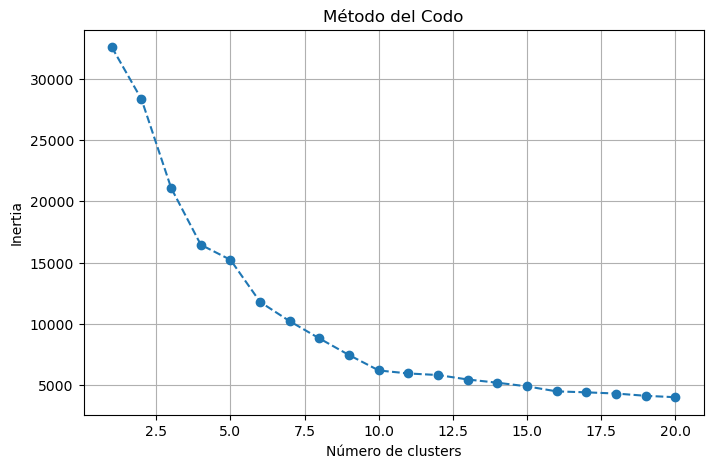

In [75]:
# Calcular la inertia para diferentes números de clusters
inertia = []
for k in range(1, 21):  # Probar de 1 a 10 clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_data)  # Usa los datos reducidos por PCA
    inertia.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(8, 5))
plt.plot(range(1, 21), inertia, marker='o', linestyle='--')
plt.xlabel('Número de clusters')
plt.ylabel('Inertia')
plt.title('Método del Codo')
plt.grid()
plt.show()

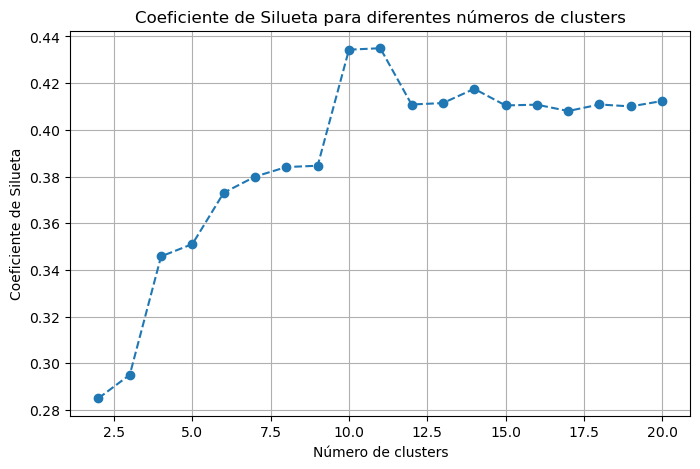

In [76]:
from sklearn.metrics import silhouette_score

# Calcular el coeficiente de silueta para diferentes números de clusters
silhouette_scores = []
for k in range(2, 21):  # Probar de 2 a 10 clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_data)
    score = silhouette_score(pca_data, kmeans.labels_)
    silhouette_scores.append(score)

# Graficar el coeficiente de silueta
plt.figure(figsize=(8, 5))
plt.plot(range(2, 21), silhouette_scores, marker='o', linestyle='--')
plt.xlabel('Número de clusters')
plt.ylabel('Coeficiente de Silueta')
plt.title('Coeficiente de Silueta para diferentes números de clusters')
plt.grid()
plt.show()

In [77]:
# Aplicar el algoritmo K-Means para clustering
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(df_analysis)

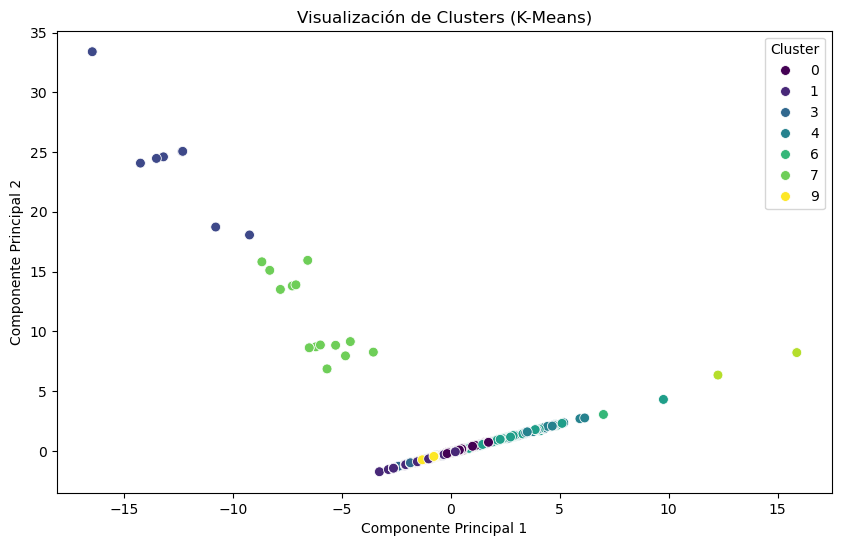

In [78]:

# Agregar los clusters al DataFrame original
df_analysis['Cluster'] = clusters

# Visualizar los clusters en el espacio reducido por PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=clusters, palette="viridis", s=50)
plt.title("Visualización de Clusters (K-Means)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(title="Cluster")
plt.show()

In [79]:
import plotly.express as px

# Crear un DataFrame con los datos de PCA y clusters
df_pca = pd.DataFrame(pca_data[:,:3], columns=['PC1', 'PC2', 'PC3'])  # Asegúrate de que pca_data tenga al menos 3 componentes
df_pca['Cluster'] = clusters  # Agregar los clusters al DataFrame

# Graficar en 3D con plotly
fig = px.scatter_3d(
    df_pca,
    x='PC1', y='PC2', z='PC3',  # Ejes del gráfico
    color='Cluster',            # Colorear por cluster
    title="Visualización de Clusters en 3D (K-Means)",
    opacity=0.3,                # Transparencia de los puntos
    size_max=1,                 # Tamaño máximo de los puntos
    symbol_sequence=['circle'], # Usar círculos como símbolo
    color_continuous_scale='Viridis'  # Paleta de colores
)

# Ajustar el tamaño del gráfico
fig.update_layout(
    width=600,  # Ancho del gráfico
    height=600   # Alto del gráfico
)

# Mostrar el gráfico interactivo
fig.show()

In [80]:
# Mostrar el tamaño de cada cluster
cluster_sizes = df_analysis['Cluster'].value_counts()
print("\nTamaño de cada cluster:")
cluster_sizes


Tamaño de cada cluster:


Cluster
0    1278
1     997
9     629
5     454
3     222
4     182
7      16
2       8
8       2
6       1
Name: count, dtype: int64

In [81]:
# Calcular las características promedio de cada cluster
numeric_columns = df_analysis.select_dtypes('number')
cluster_means = numeric_columns.groupby(df_analysis['Cluster']).mean()
cluster_means.T

Cluster            0         1         2         3         4         5  \
VPH_SNBIEN -0.038975 -0.038975 -0.038975 -0.038975 -0.038975 -0.038975   
VPH_PC     -0.496554 -0.496554  2.293740 -0.496554 -0.496554 -0.496554   
VPH_DSADMA -0.495561 -0.495561  2.798117 -0.495561 -0.495561 -0.495561   
VPH_CVJ    -0.442537 -0.442537  2.112990 -0.442537 -0.442537 -0.442537   
P_15A17_F  -0.353840 -0.353840  1.636759 -0.353840 -0.353840 -0.353840   
...              ...       ...       ...       ...       ...       ...   
PRO_OCUP_C -0.980939 -0.980939  1.007243 -0.980939 -0.980939 -0.980939   
P_6A11     -0.374703 -0.374703  1.915382 -0.374515 -0.374703 -0.374703   
VPH_C_ELEC -0.494797 -0.494797  2.787559 -0.494797 -0.494797 -0.494797   
VPH_SPMVPI -0.478820 -0.478820  2.245325 -0.478820 -0.478820 -0.478820   
Cluster     0.000000  1.000000  2.000000  3.000000  4.000000  5.000000   

Cluster            6         7         8         9  
VPH_SNBIEN -0.038975  0.951984 -0.038975 -0.038975  
VPH_PC     -0.496554  1.003426 -0.496554 -0.496554  
VPH_DSADMA -0.495561  1.026536 -0.495561 -0.495561  
VPH_CVJ    -0.442537  0.954661 -0.442537 -0.442537  
P_15A17_F  -0.353840  0.568410 -0.353840 -0.353840  
...              ...       ...       ...       ...  
PRO_OCUP_C -0.980939  1.236099 -0.980939 -0.980939  
P_6A11     -0.374703  0.725998 -0.374703 -0.374703  
VPH_C_ELEC -0.494797  1.021688 -0.494797 -0.494797  
VPH_SPMVPI -0.478820  0.927360 -0.478820 -0.478820  
Cluster     6.000000  7.000000  8.000000  9.000000  

[99 rows x 10 columns]

In [82]:
df_analysis.columns

Index(['VPH_SNBIEN', 'VPH_PC', 'VPH_DSADMA', 'VPH_CVJ', 'P_15A17_F', 'P_3A5_M',
       'POB65_MAS', 'P_8A14_F', 'baños', 'P18YM_PB_F', 'VPH_LETR',
       'TVIVPARHAB', 'TVIVPAR', 'VPH_SINTIC', 'VPH_S_ELEC', 'VPH_DRENAJ',
       'P_0A2_M', 'P_60YMAS_M', 'P_15A17_M', 'VIVPAR_DES', 'VPH_RADIO',
       'VIVTOT', 'VPH_AGUAFV', 'POBMAS', 'VPH_2CUART', 'P_8A14_M', 'recamaras',
       'POBTOT', 'P_18YMAS_M', 'P_0A2_F', 'P_18YMAS', 'P_15A17', 'P_18A24',
       'VPH_NDACMM', 'VPH_EXCSA', 'P_3A5_F', 'VPH_2YMASD', 'OCUPVIVPAR',
       'VPH_1DOR', 'P_18A24_F', 'P_3A5', 'P_18YMAS_F', 'VPH_AUTOM',
       'es_amueblado', 'VPH_1CUART', 'VPH_HMICRO', 'VIVPARH_CV', 'VPH_SINLTC',
       'VPH_CEL', 'VPH_AEASP', 'VPH_CISTER', 'P18YM_PB', 'lote_m2',
       'PHOGJEF_M', 'VPH_3YMASC', 'VPH_MOTO', 'VPH_INTER', 'P_15A49_F',
       'VPH_NDEAED', 'P_12A14_M', 'VPH_STVP', 'HOGJEF_F', 'PHOGJEF_F',
       'PROM_OCUP', 'VPH_C_SERV', 'P_60YMAS', 'VPH_TV', 'P_6A11_M', 'P_12A14',
       'P_12A14_F', 'VPH_SINCINT', 'P_0A2

In [83]:
loadings = pd.DataFrame(
            pca.components_.T,
            columns=[f'PC{i+1}' for i in range(pca.n_components_)],
            index=df_analysis.drop('Cluster',axis =1).columns
        )

In [84]:
feature_importance_pca = np.sum(
            loadings.abs() * pca.explained_variance_ratio_, axis=1
        )
feature_importance_pca = feature_importance_pca.sort_values(ascending=False)

In [85]:
pd.set_option('display.max_rows', None)  # Mostrar todas las filas
feature_importance_pca.sort_values(ascending=False, inplace = True)

In [86]:
feature_importance_pca

recamaras          3.195370e-01
estacionamiento    2.867651e-01
es_penthouse       2.653864e-01
baños              2.636665e-01
es_amueblado       2.128326e-01
lote_m2            1.558832e-01
VPH_BICI           6.566732e-02
VPH_NDACMM         5.713330e-02
VPH_SINRTV         5.563111e-02
VIVPAR_HAB         5.367711e-02
TVIVPAR            5.149375e-02
VPH_TINACO         4.896733e-02
HOGJEF_F           4.874684e-02
VPH_1DOR           4.861429e-02
PHOGJEF_F          4.590419e-02
VPH_MOTO           4.537767e-02
P_60YMAS_F         4.497595e-02
VPH_REFRI          4.450122e-02
TVIVHAB            4.423387e-02
VPH_AEASP          4.414400e-02
VPH_CISTER         4.414316e-02
VPH_C_SERV         4.405264e-02
VPH_DRENAJ         4.403931e-02
VPH_DSADMA         4.400891e-02
VPH_AGUADV         4.389600e-02
VPH_CEL            4.388103e-02
VPH_EXCSA          4.386512e-02
VPH_C_ELEC         4.385033e-02
TOTHOG             4.384511e-02
TVIVPARHAB         4.384511e-02
VIVPARH_CV         4.384394e-02
VIVTOT  

In [87]:
feature_importance_pca.index

Index(['recamaras', 'estacionamiento', 'es_penthouse', 'baños', 'es_amueblado',
       'lote_m2', 'VPH_BICI', 'VPH_NDACMM', 'VPH_SINRTV', 'VIVPAR_HAB',
       'TVIVPAR', 'VPH_TINACO', 'HOGJEF_F', 'VPH_1DOR', 'PHOGJEF_F',
       'VPH_MOTO', 'P_60YMAS_F', 'VPH_REFRI', 'TVIVHAB', 'VPH_AEASP',
       'VPH_CISTER', 'VPH_C_SERV', 'VPH_DRENAJ', 'VPH_DSADMA', 'VPH_AGUADV',
       'VPH_CEL', 'VPH_EXCSA', 'VPH_C_ELEC', 'TOTHOG', 'TVIVPARHAB',
       'VIVPARH_CV', 'VIVTOT', 'VPH_TV', 'VPH_3YMASC', 'VPH_RADIO',
       'VPH_INTER', 'P18YM_PB', 'POB65_MAS', 'VPH_SINCINT', 'P18YM_PB_F',
       'VPH_LAVAD', 'P18YM_PB_M', 'P_60YMAS', 'P_18YMAS_F', 'VPH_TELEF',
       'POBHOG', 'OCUPVIVPAR', 'VPH_2CUART', 'HOGJEF_M', 'POBFEM',
       'VPH_2YMASD', 'VPH_HMICRO', 'VPH_PC', 'P_0A2_M', 'VPH_SPMVPI',
       'P_15A49_F', 'P_0A2', 'POBTOT', 'PHOGJEF_M', 'VPH_CVJ', 'PRO_OCUP_C',
       'P_3A5_F', 'P_18YMAS', 'P_18A24', 'P_18A24_F', 'P_3A5', 'P_60YMAS_M',
       'VPH_STVP', 'P_8A14_M', 'P_0A2_F', 'PROM_OCUP', 'P

In [88]:
#random_position = feature_importance_pca.index.get_loc('random')
# Quedarse solo con las features antes de 'random'
#filtered_features = feature_importance_pca.iloc[:random_position]
        

In [89]:
#filtered_features.index

In [90]:
#final_features = list(filtered_features.index)
final_features = list(feature_importance_pca.index)

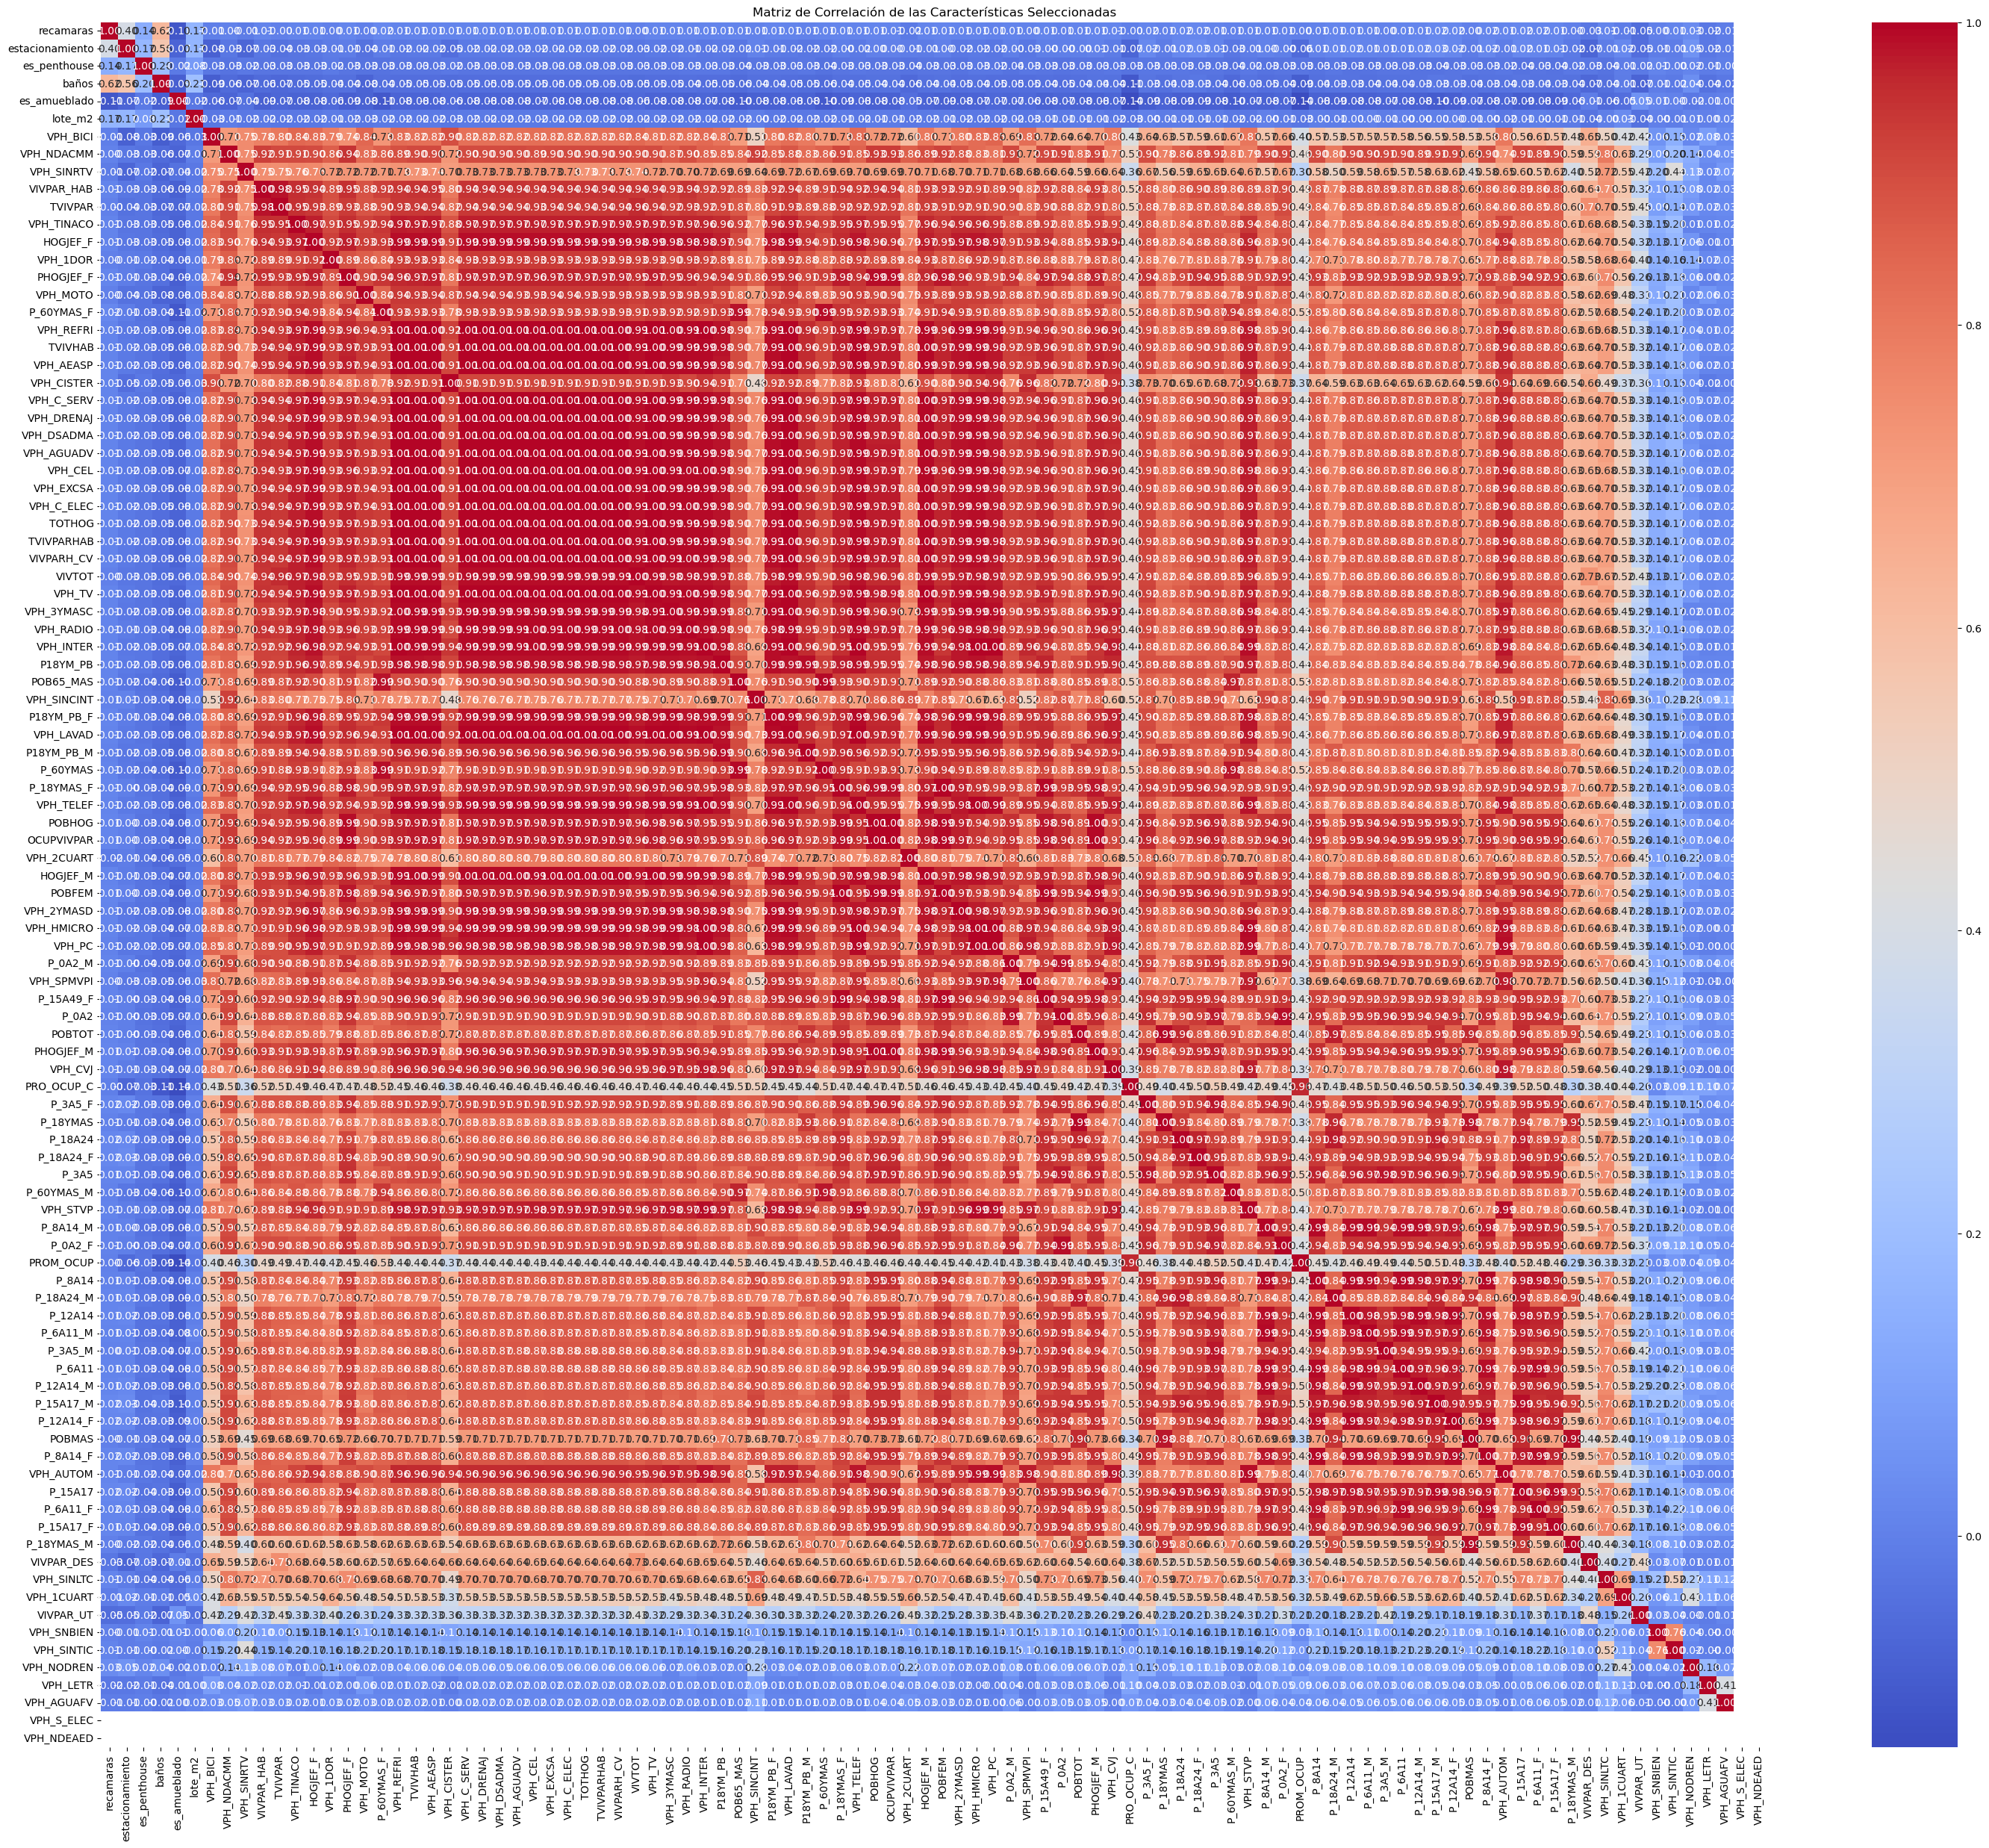

In [91]:
# Calcular la matriz de correlación para las características seleccionadas
correlation_matrix = df[final_features].corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(36, 30))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Matriz de Correlación de las Características Seleccionadas")
plt.show()

In [92]:
# Establecer un umbral para considerar alta correlación
correlation_threshold = 0.60

# Identificar pares de características altamente correlacionadas
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            high_corr_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j]))

print(f"Pares de características altamente correlacionadas (umbral > {correlation_threshold}):")
high_corr_pairs

Pares de características altamente correlacionadas (umbral > 0.6):


[('baños', 'recamaras'),
 ('VPH_NDACMM', 'VPH_BICI'),
 ('VPH_SINRTV', 'VPH_BICI'),
 ('VPH_SINRTV', 'VPH_NDACMM'),
 ('VIVPAR_HAB', 'VPH_BICI'),
 ('VIVPAR_HAB', 'VPH_NDACMM'),
 ('VIVPAR_HAB', 'VPH_SINRTV'),
 ('TVIVPAR', 'VPH_BICI'),
 ('TVIVPAR', 'VPH_NDACMM'),
 ('TVIVPAR', 'VPH_SINRTV'),
 ('TVIVPAR', 'VIVPAR_HAB'),
 ('VPH_TINACO', 'VPH_BICI'),
 ('VPH_TINACO', 'VPH_NDACMM'),
 ('VPH_TINACO', 'VPH_SINRTV'),
 ('VPH_TINACO', 'VIVPAR_HAB'),
 ('VPH_TINACO', 'TVIVPAR'),
 ('HOGJEF_F', 'VPH_BICI'),
 ('HOGJEF_F', 'VPH_NDACMM'),
 ('HOGJEF_F', 'VPH_SINRTV'),
 ('HOGJEF_F', 'VIVPAR_HAB'),
 ('HOGJEF_F', 'TVIVPAR'),
 ('HOGJEF_F', 'VPH_TINACO'),
 ('VPH_1DOR', 'VPH_BICI'),
 ('VPH_1DOR', 'VPH_NDACMM'),
 ('VPH_1DOR', 'VPH_SINRTV'),
 ('VPH_1DOR', 'VIVPAR_HAB'),
 ('VPH_1DOR', 'TVIVPAR'),
 ('VPH_1DOR', 'VPH_TINACO'),
 ('VPH_1DOR', 'HOGJEF_F'),
 ('PHOGJEF_F', 'VPH_BICI'),
 ('PHOGJEF_F', 'VPH_NDACMM'),
 ('PHOGJEF_F', 'VPH_SINRTV'),
 ('PHOGJEF_F', 'VIVPAR_HAB'),
 ('PHOGJEF_F', 'TVIVPAR'),
 ('PHOGJEF_F', 'VPH_TINAC

In [93]:
# Crear un conjunto para almacenar las características a eliminar
features_to_remove = set()

# Para cada par de características correlacionadas, eliminar la menos importante según PCA
for feature1, feature2 in high_corr_pairs:
    if feature_importance_pca[feature1] < feature_importance_pca[feature2]:
        features_to_remove.add(feature1)
    else:
        features_to_remove.add(feature2)

# Filtrar las características finales eliminando las correlacionadas menos importantes
final_features_filtered = [feature for feature in final_features if feature not in features_to_remove]

print(f"Características finales después de eliminar correlacionadas: {len(final_features_filtered)}")
final_features_filtered

Características finales después de eliminar correlacionadas: 14


['recamaras',
 'estacionamiento',
 'es_penthouse',
 'es_amueblado',
 'lote_m2',
 'VPH_BICI',
 'PRO_OCUP_C',
 'VIVPAR_UT',
 'VPH_SNBIEN',
 'VPH_NODREN',
 'VPH_LETR',
 'VPH_AGUAFV',
 'VPH_S_ELEC',
 'VPH_NDEAED']

In [94]:
final_features = final_features_filtered.copy()

# Entrenamiento de Modelos

## Regresión Lineal

Usando todas las 14 features
Forma del dataset: X (8289, 14), y (8289,)
Features seleccionadas: ['recamaras', 'estacionamiento', 'es_penthouse', 'es_amueblado', 'lote_m2', 'VPH_BICI', 'PRO_OCUP_C', 'VIVPAR_UT', 'VPH_SNBIEN', 'VPH_NODREN', 'VPH_LETR', 'VPH_AGUAFV', 'VPH_S_ELEC', 'VPH_NDEAED']

Valores faltantes en X: 3559
Valores faltantes en y: 0
Después de eliminar NaN: X (6562, 14), y (6562,)

División de datos:
Entrenamiento: X (5249, 14), y (5249,)
Prueba: X (1313, 14), y (1313,)

Entrenando el modelo...
Entrenamiento completado en 0.00 segundos.

Resultados Entrenamiento:
Error cuadrático medio (MSE): 513,285,414.79
Raíz del error cuadrático medio (RMSE): 22,655.80
Error absoluto medio (MAE): 14,692.08
Coeficiente de determinación (R²): 0.4630

Resultados Prueba:
Error cuadrático medio (MSE): 492,307,706.49
Raíz del error cuadrático medio (RMSE): 22,188.01
Error absoluto medio (MAE): 14,695.99
Coeficiente de determinación (R²): 0.4731

Validación cruzada (5-fold):
R² promedio: 0.4

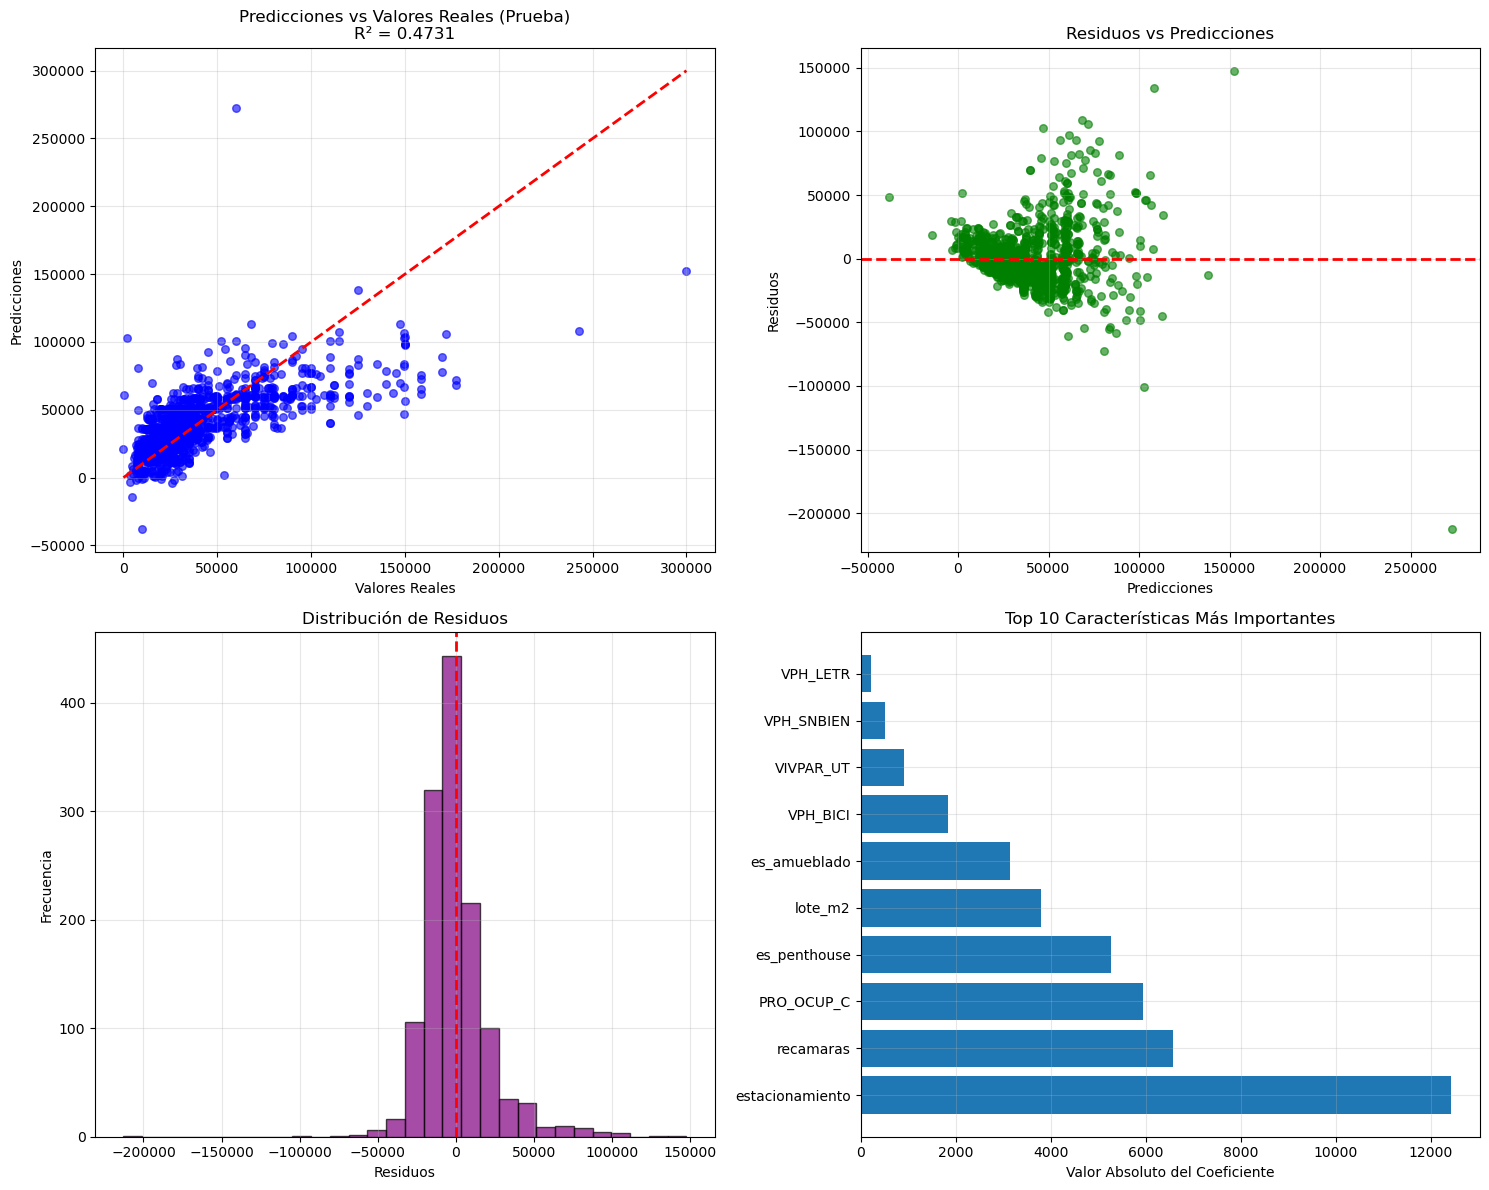


Comparación Entrenamiento vs Prueba:
Métrica  Entrenamiento       Prueba
    MSE   5.132854e+08 4.923077e+08
   RMSE   2.265580e+04 2.218801e+04
    MAE   1.469208e+04 1.469599e+04
     R²   4.629791e-01 4.731401e-01

⚠️  Modelo con bajo rendimiento:
   R² en prueba: 0.4731

Modelo entrenado exitosamente con 14 características


In [95]:
# Regresión Lineal con Pipeline Completo
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import time

# Seleccionar las características (X) y la variable objetivo (y)
target_column = 'precio_mxn'

# Filtrar features antes de 'random' si existe
if 'random' in final_features:
    final_features_filtered = final_features[:final_features.index('random')]
    print(f"Filtradas {len(final_features_filtered)} features antes de 'random'")
else:
    final_features_filtered = final_features
    print(f"Usando todas las {len(final_features_filtered)} features")

X = df[final_features_filtered]
y = df[target_column]

print(f"Forma del dataset: X {X.shape}, y {y.shape}")
print(f"Features seleccionadas: {final_features_filtered}")

# Verificar valores faltantes
print(f"\nValores faltantes en X: {X.isnull().sum().sum()}")
print(f"Valores faltantes en y: {y.isnull().sum()}")

# Eliminar filas con valores faltantes si los hay
if X.isnull().sum().sum() > 0 or y.isnull().sum() > 0:
    mask = ~(X.isnull().any(axis=1) | y.isnull())
    X = X[mask]
    y = y[mask]
    print(f"Después de eliminar NaN: X {X.shape}, y {y.shape}")

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=None  # Para regresión no usamos stratify
)

print(f"\nDivisión de datos:")
print(f"Entrenamiento: X {X_train.shape}, y {y_train.shape}")
print(f"Prueba: X {X_test.shape}, y {y_test.shape}")

# Crear el pipeline con StandardScaler y LinearRegression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

# Entrenar el modelo
print("\nEntrenando el modelo...")
start_time = time.time()
pipeline.fit(X_train, y_train)
end_time = time.time()

training_time = end_time - start_time 
print(f"Entrenamiento completado en {training_time:.2f} segundos.")

# Realizar predicciones
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)

# Evaluar el modelo
def evaluate_model(y_true, y_pred, dataset_name=""):
    """Función para evaluar el modelo con múltiples métricas"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\nResultados {dataset_name}:")
    print(f"Error cuadrático medio (MSE): {mse:,.2f}")
    print(f"Raíz del error cuadrático medio (RMSE): {rmse:,.2f}")
    print(f"Error absoluto medio (MAE): {mae:,.2f}")
    print(f"Coeficiente de determinación (R²): {r2:.4f}")
    
    return {'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2}

# Evaluar en entrenamiento y prueba
train_metrics = evaluate_model(y_train, y_pred_train, "Entrenamiento")
test_metrics = evaluate_model(y_test, y_pred_test, "Prueba")

# Validación cruzada
print(f"\nValidación cruzada (5-fold):")
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2')
print(f"R² promedio: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

cv_scores_rmse = cross_val_score(pipeline, X_train, y_train, cv=5, 
                                scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores_rmse)
print(f"RMSE promedio: {cv_rmse.mean():,.2f} (+/- {cv_rmse.std() * 2:,.2f})")

# Análisis de coeficientes
scaler = pipeline.named_steps['scaler']
regressor = pipeline.named_steps['regressor']

# Obtener coeficientes e importancia
feature_importance = pd.DataFrame({
    'feature': final_features_filtered,
    'coefficient': regressor.coef_,
    'abs_coefficient': np.abs(regressor.coef_)
}).sort_values('abs_coefficient', ascending=False)

print(f"\nTop 10 características más importantes:")
print(feature_importance.head(10).to_string(index=False))

# Visualizaciones mejoradas
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Predicciones vs Valores Reales (Prueba)
axes[0,0].scatter(y_test, y_pred_test, alpha=0.6, color='blue', s=30)
axes[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
               color='red', linestyle='--', linewidth=2)
axes[0,0].set_title(f"Predicciones vs Valores Reales (Prueba)\nR² = {test_metrics['r2']:.4f}")
axes[0,0].set_xlabel("Valores Reales")
axes[0,0].set_ylabel("Predicciones")
axes[0,0].grid(True, alpha=0.3)

# 2. Residuos vs Predicciones
residuals_test = y_test - y_pred_test
axes[0,1].scatter(y_pred_test, residuals_test, alpha=0.6, color='green', s=30)
axes[0,1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0,1].set_title("Residuos vs Predicciones")
axes[0,1].set_xlabel("Predicciones")
axes[0,1].set_ylabel("Residuos")
axes[0,1].grid(True, alpha=0.3)

# 3. Distribución de residuos
axes[1,0].hist(residuals_test, bins=30, alpha=0.7, color='purple', edgecolor='black')
axes[1,0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1,0].set_title("Distribución de Residuos")
axes[1,0].set_xlabel("Residuos")
axes[1,0].set_ylabel("Frecuencia")
axes[1,0].grid(True, alpha=0.3)

# 4. Importancia de características (Top 10)
top_10_features = feature_importance.head(10)
axes[1,1].barh(range(len(top_10_features)), top_10_features['abs_coefficient'])
axes[1,1].set_yticks(range(len(top_10_features)))
axes[1,1].set_yticklabels(top_10_features['feature'])
axes[1,1].set_title("Top 10 Características Más Importantes")
axes[1,1].set_xlabel("Valor Absoluto del Coeficiente")
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Comparación Entrenamiento vs Prueba
comparison_df = pd.DataFrame({
    'Métrica': ['MSE', 'RMSE', 'MAE', 'R²'],
    'Entrenamiento': [train_metrics['mse'], train_metrics['rmse'], 
                     train_metrics['mae'], train_metrics['r2']],
    'Prueba': [test_metrics['mse'], test_metrics['rmse'], 
              test_metrics['mae'], test_metrics['r2']]
})

print(f"\nComparación Entrenamiento vs Prueba:")
print(comparison_df.to_string(index=False))

# Detectar posible overfitting
if train_metrics['r2'] - test_metrics['r2'] > 0.1:
    print(f"\n⚠️  Posible overfitting detectado:")
    print(f"   Diferencia R²: {train_metrics['r2'] - test_metrics['r2']:.4f}")
elif test_metrics['r2'] < 0.5:
    print(f"\n⚠️  Modelo con bajo rendimiento:")
    print(f"   R² en prueba: {test_metrics['r2']:.4f}")
else:
    print(f"\n✅ Modelo con buen rendimiento y generalización")

# Guardar el modelo entrenado y métricas
model_results_linear = {
    'pipeline': pipeline,
    'train_metrics': train_metrics,
    'test_metrics': test_metrics,
    'feature_importance': feature_importance,
    'cv_scores': cv_scores,
    'training_time': training_time
}

print(f"\nModelo entrenado exitosamente con {len(final_features_filtered)} características")


### RandomForestRegressor

#### Ajuste de Hiperparámetros para Random Forest

In [98]:
# Búsqueda de hiperparámetros para RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Definir el pipeline (sin el modelo final)
pipeline_rf_grid = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor(random_state=42, n_jobs=-1))
])

# Definir la parrilla de parámetros a probar (reducida para rapidez)
param_grid_rf = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [10, 20],
    'regressor__min_samples_split': [2, 5],
    'regressor__min_samples_leaf': [1, 2]
}

# Configurar GridSearchCV
grid_search_rf = GridSearchCV(
    pipeline_rf_grid, 
    param_grid_rf, 
    cv=3,  # 3-fold cross-validation para rapidez
    scoring='r2', 
    n_jobs=-1, 
    verbose=2
)

print("Iniciando búsqueda de hiperparámetros para Random Forest...")
start_time_grid_rf = time.time()
grid_search_rf.fit(X_train, y_train)
end_time_grid_rf = time.time()

print(f"Búsqueda completada en {end_time_grid_rf - start_time_grid_rf:.2f} segundos.")
print(f"Mejores parámetros encontrados para Random Forest: {grid_search_rf.best_params_}")
print(f"Mejor R² en validación cruzada: {grid_search_rf.best_score_:.4f}")

# Guardar el mejor estimador
best_rf_pipeline = grid_search_rf.best_estimator_

Iniciando búsqueda de hiperparámetros para Random Forest...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] END regressor__max_depth=10, regressor__min_samples_leaf=1, regressor__min_samples_split=2, regressor__n_estimators=100; total time=   0.3s
[CV] END regressor__max_depth=10, regressor__min_samples_leaf=1, regressor__min_samples_split=5, regressor__n_estimators=100; total time=   0.2s
[CV] END regressor__max_depth=10, regressor__min_samples_leaf=1, regressor__min_samples_split=2, regressor__n_estimators=100; total time=   0.2s
[CV] END regressor__max_depth=10, regressor__min_samples_leaf=1, regressor__min_samples_split=2, regressor__n_estimators=100; total time=   0.5s
[CV] END regressor__max_depth=10, regressor__min_samples_leaf=1, regressor__min_samples_split=5, regressor__n_estimators=200; total time=   1.0s
[CV] END regressor__max_depth=10, regressor__min_samples_leaf=1, regressor__min_samples_split=2, regressor__n_estimators=200; total time=   1.2s
[CV] END 

In [ ]:
# Regresión No Lineal con Pipeline (Random Forest Regressor)
from sklearn.model_selection import train_test_split, cross_val_score
# Importamos el nuevo modelo: Random Forest Regressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- Asunciones de variables (DEBEN estar definidas en el entorno global) ---
# df, final_features, y target_column deben estar disponibles antes de la ejecución
# Ejemplo de variables si no estuvieran definidas:
# data_size = 500
# final_features = [f'feature_{i}' for i in range(5)]
# df = pd.DataFrame(np.random.rand(data_size, 5), columns=final_features)
# df['precio_mxn'] = df.iloc[:, 0] * 100 + df.iloc[:, 1] * 50 + np.random.randn(data_size) * 10
# target_column = 'precio_mxn'
# -------------------------------------------------------------------------

# Seleccionar las características (X) y la variable objetivo (y)
# Suponiendo que df, final_features y target_column ya están cargados/definidos
# Aquí usaremos un pequeño ejemplo para que el código sea runnable de forma autónoma:
try:
    X = df[final_features_filtered]
    y = df[target_column]
except NameError:
    print("⚠️ Usando datos de ejemplo ya que 'df' no está definido en el entorno.")
    data_size = 1000
    final_features = [f'area_m2', 'num_habitaciones', 'distancia_centro_km', 'antiguedad_anos', 'dummy_col']
    df = pd.DataFrame(np.random.rand(data_size, 5), columns=final_features)
    df['precio_mxn'] = (df['area_m2'] * 500000) + (df['num_habitaciones'] * 100000) + (np.random.randn(data_size) * 50000)
    target_column = 'precio_mxn'
    final_features_filtered = final_features
    X = df[final_features_filtered]
    y = df[target_column]


print(f"Forma del dataset: X {X.shape}, y {y.shape}")
print(f"Features seleccionadas: {final_features_filtered}")

# Verificar y limpiar valores faltantes (mismo código que el original)
if X.isnull().sum().sum() > 0 or y.isnull().sum() > 0:
    mask = ~(X.isnull().any(axis=1) | y.isnull())
    X = X[mask]
    y = y[mask]
    print(f"Después de eliminar NaN: X {X.shape}, y {y.shape}")

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

print(f"\nDivisión de datos:")
print(f"Entrenamiento: X {X_train.shape}, y {y_train.shape}")
print(f"Prueba: X {X_test.shape}, y {y_test.shape}")

# --- Usar el mejor pipeline encontrado por GridSearchCV ---
pipeline = best_rf_pipeline

# El modelo ya está entrenado, pero medimos el tiempo de re-entrenamiento para consistencia
print("\nRe-entrenando el mejor modelo Random Forest en todo el set de entrenamiento...")
start_time = time.time()
pipeline.fit(X_train, y_train)
end_time = time.time()

training_time = end_time - start_time
print(f"Entrenamiento completado en {training_time:.2f} segundos.")

# Realizar predicciones
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)

# Evaluar el modelo (función de evaluación reutilizada)
def evaluate_model(y_true, y_pred, dataset_name=""):
    """Función para evaluar el modelo con múltiples métricas"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\nResultados {dataset_name}:")
    print(f"Error cuadrático medio (MSE): {mse:,.2f}")
    print(f"Raíz del error cuadrático medio (RMSE): {rmse:,.2f}")
    print(f"Error absoluto medio (MAE): {mae:,.2f}")
    print(f"Coeficiente de determinación (R²): {r2:.4f}")
    
    return {'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2}

# Evaluar en entrenamiento y prueba
train_metrics = evaluate_model(y_train, y_pred_train, "Entrenamiento (Random Forest Sintonizado)")
test_metrics = evaluate_model(y_test, y_pred_test, "Prueba (Random Forest Sintonizado)")

# Validación cruzada
print(f"\nValidación cruzada (5-fold) con el modelo sintonizado:")
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)
print(f"R² promedio: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

cv_scores_rmse = cross_val_score(pipeline, X_train, y_train, cv=5, 
                                scoring='neg_mean_squared_error', n_jobs=-1)
cv_rmse = np.sqrt(-cv_scores_rmse)
print(f"RMSE promedio: {cv_rmse.mean():,.2f} (+/- {cv_rmse.std() * 2:,.2f})")

# Análisis de Importancia de Características (diferente al de Regresión Lineal)
regressor = pipeline.named_steps['regressor']

# Obtener la importancia de las características del Random Forest
feature_importance = pd.DataFrame({
    'feature': final_features_filtered,
    'importance': regressor.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 10 características más importantes (Random Forest Sintonizado):")
# Usamos 'importance' en lugar de 'abs_coefficient'
print(feature_importance.head(10).to_string(index=False))

# Visualizaciones mejoradas (reutilizando la estructura de la gráfica)
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Predicciones vs Valores Reales (Prueba)
axes[0,0].scatter(y_test, y_pred_test, alpha=0.6, color='#FF5733', s=30)
axes[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
               color='#33FF57', linestyle='--', linewidth=2)
axes[0,0].set_title(f"Predicciones vs Valores Reales (Prueba)\nR² = {test_metrics['r2']:.4f}", 
                    fontsize=14, color='#333333')
axes[0,0].set_xlabel("Valores Reales (precio_mxn)", fontsize=12)
axes[0,0].set_ylabel("Predicciones (precio_mxn)", fontsize=12)
axes[0,0].grid(True, alpha=0.3, linestyle=':')

# 2. Residuos vs Predicciones
residuals_test = y_test - y_pred_test
axes[0,1].scatter(y_pred_test, residuals_test, alpha=0.6, color='#33AFFF', s=30)
axes[0,1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0,1].set_title("Residuos vs Predicciones (Idealmente aleatorio)", 
                    fontsize=14, color='#333333')
axes[0,1].set_xlabel("Predicciones", fontsize=12)
axes[0,1].set_ylabel("Residuos (Error)", fontsize=12)
axes[0,1].grid(True, alpha=0.3, linestyle=':')

# 3. Distribución de residuos
axes[1,0].hist(residuals_test, bins=30, alpha=0.8, color='#AFFF33', edgecolor='black')
axes[1,0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1,0].set_title("Distribución de Residuos (Idealmente normal y centrado en 0)", 
                    fontsize=14, color='#333333')
axes[1,0].set_xlabel("Residuos", fontsize=12)
axes[1,0].set_ylabel("Frecuencia", fontsize=12)
axes[1,0].grid(True, alpha=0.3, linestyle=':')

# 4. Importancia de características (Top 10)
top_10_features = feature_importance.head(10)
axes[1,1].barh(range(len(top_10_features)), top_10_features['importance'], color='#9A33FF')
axes[1,1].set_yticks(range(len(top_10_features)))
axes[1,1].set_yticklabels(top_10_features['feature'], fontsize=10)
axes[1,1].set_title("Top 10 Características Más Importantes (Random Forest)", 
                    fontsize=14, color='#333333')
axes[1,1].set_xlabel("Importancia (Gini Impurity)", fontsize=12)
axes[1,1].invert_yaxis() # Pone la más importante arriba
axes[1,1].grid(axis='x', alpha=0.3, linestyle=':')

plt.suptitle("Evaluación del Modelo Random Forest Regressor Sintonizado", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

# Comparación Entrenamiento vs Prueba
comparison_df = pd.DataFrame({
    'Métrica': ['MSE', 'RMSE', 'MAE', 'R²'],
    'Entrenamiento': [train_metrics['mse'], train_metrics['rmse'], 
                     train_metrics['mae'], train_metrics['r2']],
    'Prueba': [test_metrics['mse'], test_metrics['rmse'], 
              test_metrics['mae'], test_metrics['r2']]
})

print(f"\nComparación Entrenamiento vs Prueba:")
print(comparison_df.to_string(index=False))

# Detectar posible overfitting
# En Random Forest, la diferencia R² tiende a ser mayor, pero el R² de prueba debe ser alto.
r2_diff = train_metrics['r2'] - test_metrics['r2']
if r2_diff > 0.15: # Un umbral más alto para modelos de árbol
    print(f"\n⚠️  Random Forest detectado con posible sobreajuste (Overfitting):")
    print(f"   Diferencia R² (Entrenamiento - Prueba): {r2_diff:.4f}")
    print("   Considera reducir max_depth o aumentar min_samples_split.")
elif test_metrics['r2'] < 0.6:
    print(f"\n⚠️  Modelo con bajo rendimiento:")
    print(f"   R² en prueba: {test_metrics['r2']:.4f}")
else:
    print(f"\n✅ Modelo Random Forest con buen rendimiento y generalización.")

# Guardar el modelo entrenado y métricas (actualizado)
model_results_rf_tuned = {
    'pipeline': pipeline,
    'train_metrics': train_metrics,
    'test_metrics': test_metrics,
    'feature_importance': feature_importance,
    'cv_scores': cv_scores,
    'training_time': training_time
}

print(f"\nModelo Random Forest Sintonizado entrenado exitosamente con {len(final_features_filtered)} características")


Forma del dataset: X (8289, 14), y (8289,)
Features seleccionadas: ['recamaras', 'estacionamiento', 'es_penthouse', 'es_amueblado', 'lote_m2', 'VPH_BICI', 'PRO_OCUP_C', 'VIVPAR_UT', 'VPH_SNBIEN', 'VPH_NODREN', 'VPH_LETR', 'VPH_AGUAFV', 'VPH_S_ELEC', 'VPH_NDEAED']
Después de eliminar NaN: X (6562, 14), y (6562,)

División de datos:
Entrenamiento: X (5249, 14), y (5249,)
Prueba: X (1313, 14), y (1313,)


NameError: name 'best_rf_pipeline' is not defined

## GradientBoostingRegressor

#### Ajuste de Hiperparámetros para Gradient Boosting

In [ ]:
# Búsqueda de hiperparámetros para GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

# Definir el pipeline
pipeline_gbm_grid = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', GradientBoostingRegressor(random_state=42))
])

# Definir la parrilla de parámetros
param_grid_gbm = {
    'regressor__n_estimators': [100, 200],
    'regressor__learning_rate': [0.05, 0.1],
    'regressor__max_depth': [3, 5],
    'regressor__subsample': [0.8, 1.0]
}

# Configurar GridSearchCV
grid_search_gbm = GridSearchCV(
    pipeline_gbm_grid, 
    param_grid_gbm, 
    cv=3, 
    scoring='r2', 
    n_jobs=-1, 
    verbose=2
)

print("Iniciando búsqueda de hiperparámetros para Gradient Boosting...")
start_time_grid_gbm = time.time()
grid_search_gbm.fit(X_train, y_train)
end_time_grid_gbm = time.time()

print(f"Búsqueda completada en {end_time_grid_gbm - start_time_grid_gbm:.2f} segundos.")
print(f"Mejores parámetros encontrados para Gradient Boosting: {grid_search_gbm.best_params_}")
print(f"Mejor R² en validación cruzada: {grid_search_gbm.best_score_:.4f}")

# Guardar el mejor estimador
best_gbm_pipeline = grid_search_gbm.best_estimator_

In [ ]:
# Regresión No Lineal con Pipeline (Gradient Boosting Regressor)
from sklearn.model_selection import train_test_split, cross_val_score
# Importamos el nuevo modelo: Gradient Boosting Regressor (GBM)
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- Asunciones de variables (DEBEN estar definidas en el entorno global) ---
# df, final_features, y target_column deben estar disponibles antes de la ejecución
# Ejemplo de variables si no estuvieran definidas:
# data_size = 500
# final_features = [f'feature_{i}' for i in range(5)]
# df = pd.DataFrame(np.random.rand(data_size, 5), columns=final_features)
# df['precio_mxn'] = df.iloc[:, 0] * 100 + df.iloc[:, 1] * 50 + np.random.randn(data_size) * 10
# target_column = 'precio_mxn'
# -------------------------------------------------------------------------

# Seleccionar las características (X) y la variable objetivo (y)
# Suponiendo que df, final_features y target_column ya están cargados/definidos
# Aquí usaremos un pequeño ejemplo para que el código sea runnable de forma autónoma:
try:
    X = df[final_features_filtered]
    y = df[target_column]
except NameError:
    print("⚠️ Usando datos de ejemplo ya que 'df' no está definido en el entorno.")
    data_size = 1000
    final_features = [f'area_m2', 'num_habitaciones', 'distancia_centro_km', 'antiguedad_anos', 'dummy_col']
    df = pd.DataFrame(np.random.rand(data_size, 5), columns=final_features)
    df['precio_mxn'] = (df['area_m2'] * 500000) + (df['num_habitaciones'] * 100000) + (np.random.randn(data_size) * 50000)
    target_column = 'precio_mxn'
    final_features_filtered = final_features
    X = df[final_features_filtered]
    y = df[target_column]


print(f"Forma del dataset: X {X.shape}, y {y.shape}")
print(f"Features seleccionadas: {final_features_filtered}")

# Verificar y limpiar valores faltantes (mismo código que el original)
if X.isnull().sum().sum() > 0 or y.isnull().sum() > 0:
    mask = ~(X.isnull().any(axis=1) | y.isnull())
    X = X[mask]
    y = y[mask]
    print(f"Después de eliminar NaN: X {X.shape}, y {y.shape}")

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

print(f"\nDivisión de datos:")
print(f"Entrenamiento: X {X_train.shape}, y {y_train.shape}")
print(f"Prueba: X {X_test.shape}, y {y_test.shape}")

# --- Usar el mejor pipeline encontrado por GridSearchCV ---
pipeline = best_gbm_pipeline

# Entrenar el modelo
print("\nEntrenando el modelo Gradient Boosting Regressor (GBM) Sintonizado...")
start_time = time.time()
pipeline.fit(X_train, y_train)
end_time = time.time()

training_time = end_time - start_time
print(f"Entrenamiento completado en {training_time:.2f} segundos.")

# Realizar predicciones
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)

# Evaluar el modelo (función de evaluación reutilizada)
def evaluate_model(y_true, y_pred, dataset_name=""):
    """Función para evaluar el modelo con múltiples métricas"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\nResultados {dataset_name}:")
    print(f"Error cuadrático medio (MSE): {mse:,.2f}")
    print(f"Raíz del error cuadrático medio (RMSE): {rmse:,.2f}")
    print(f"Error absoluto medio (MAE): {mae:,.2f}")
    print(f"Coeficiente de determinación (R²): {r2:.4f}")
    
    return {'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2}

# Evaluar en entrenamiento y prueba
train_metrics = evaluate_model(y_train, y_pred_train, "Entrenamiento (GBM Sintonizado)")
test_metrics = evaluate_model(y_test, y_pred_test, "Prueba (GBM Sintonizado)")

# Validación cruzada
print(f"\nValidación cruzada (5-fold) con el modelo sintonizado:")
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)
print(f"R² promedio: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

cv_scores_rmse = cross_val_score(pipeline, X_train, y_train, cv=5, 
                                scoring='neg_mean_squared_error', n_jobs=-1)
cv_rmse = np.sqrt(-cv_scores_rmse)
print(f"RMSE promedio: {cv_rmse.mean():,.2f} (+/- {cv_rmse.std() * 2:,.2f})")

# Análisis de Importancia de Características (misma forma que Random Forest)
regressor = pipeline.named_steps['regressor']

# Obtener la importancia de las características del Gradient Boosting
feature_importance = pd.DataFrame({
    'feature': final_features_filtered,
    'importance': regressor.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 10 características más importantes (Gradient Boosting Sintonizado):")
print(feature_importance.head(10).to_string(index=False))

# Visualizaciones mejoradas (reutilizando la estructura de la gráfica)
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Predicciones vs Valores Reales (Prueba)
axes[0,0].scatter(y_test, y_pred_test, alpha=0.6, color='#FF5733', s=30)
axes[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
               color='#33FF57', linestyle='--', linewidth=2)
axes[0,0].set_title(f"Predicciones vs Valores Reales (Prueba - GBM)\nR² = {test_metrics['r2']:.4f}", 
                    fontsize=14, color='#333333')
axes[0,0].set_xlabel("Valores Reales (precio_mxn)", fontsize=12)
axes[0,0].set_ylabel("Predicciones (precio_mxn)", fontsize=12)
axes[0,0].grid(True, alpha=0.3, linestyle=':')

# 2. Residuos vs Predicciones
residuals_test = y_test - y_pred_test
axes[0,1].scatter(y_pred_test, residuals_test, alpha=0.6, color='#33AFFF', s=30)
axes[0,1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0,1].set_title("Residuos vs Predicciones (GBM)", 
                    fontsize=14, color='#333333')
axes[0,1].set_xlabel("Predicciones", fontsize=12)
axes[0,1].set_ylabel("Residuos (Error)", fontsize=12)
axes[0,1].grid(True, alpha=0.3, linestyle=':')

# 3. Distribución de residuos
axes[1,0].hist(residuals_test, bins=30, alpha=0.8, color='#AFFF33', edgecolor='black')
axes[1,0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1,0].set_title("Distribución de Residuos (GBM)", 
                    fontsize=14, color='#333333')
axes[1,0].set_xlabel("Residuos", fontsize=12)
axes[1,0].set_ylabel("Frecuencia", fontsize=12)
axes[1,0].grid(True, alpha=0.3, linestyle=':')

# 4. Importancia de características (Top 10)
top_10_features = feature_importance.head(10)
axes[1,1].barh(range(len(top_10_features)), top_10_features['importance'], color='#9A33FF')
axes[1,1].set_yticks(range(len(top_10_features)))
axes[1,1].set_yticklabels(top_10_features['feature'], fontsize=10)
axes[1,1].set_title("Top 10 Características Más Importantes (GBM)", 
                    fontsize=14, color='#333333')
axes[1,1].set_xlabel("Importancia", fontsize=12)
axes[1,1].invert_yaxis() # Pone la más importante arriba
axes[1,1].grid(axis='x', alpha=0.3, linestyle=':')

plt.suptitle("Evaluación del Modelo Gradient Boosting Regressor (GBM) Sintonizado", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

# Comparación Entrenamiento vs Prueba
comparison_df = pd.DataFrame({
    'Métrica': ['MSE', 'RMSE', 'MAE', 'R²'],
    'Entrenamiento': [train_metrics['mse'], train_metrics['rmse'], 
                     train_metrics['mae'], train_metrics['r2']],
    'Prueba': [test_metrics['mse'], test_metrics['rmse'], 
              test_metrics['mae'], test_metrics['r2']]
})

print(f"\nComparación Entrenamiento vs Prueba:")
print(comparison_df.to_string(index=False))

# Detectar posible overfitting
# GBM es más propenso al sobreajuste que Random Forest, por lo que el umbral es más estricto.
r2_diff = train_metrics['r2'] - test_metrics['r2']
if r2_diff > 0.08: # Bajamos el umbral para modelos de boosting (0.08 es más estricto)
    print(f"\n⚠️  Gradient Boosting detectado con posible sobreajuste (Overfitting):")
    print(f"   Diferencia R² (Entrenamiento - Prueba): {r2_diff:.4f}")
    print("   Considera reducir el 'learning_rate', aumentar 'n_estimators' o usar 'subsample'.")
elif test_metrics['r2'] < 0.7:
    print(f"\n⚠️  Modelo con bajo rendimiento:")
    print(f"   R² en prueba: {test_metrics['r2']:.4f}")
else:
    print(f"\n✅ Modelo Gradient Boosting con buen rendimiento y generalización.")

# Guardar el modelo entrenado y métricas (actualizado)
model_results_gbm_tuned = {
    'pipeline': pipeline,
    'train_metrics': train_metrics,
    'test_metrics': test_metrics,
    'feature_importance': feature_importance,
    'cv_scores': cv_scores,
    'training_time': training_time
}

print(f"\nModelo Gradient Boosting Sintonizado entrenado exitosamente con {len(final_features_filtered)} características")


#### Ajuste de Hiperparámetros para XGBoost

In [ ]:
# Búsqueda de hiperparámetros para XGBRegressor
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Definir el pipeline
pipeline_xgb_grid = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', XGBRegressor(random_state=42, n_jobs=-1, objective='reg:squarederror'))
])

# Definir la parrilla de parámetros
param_grid_xgb = {
    'regressor__n_estimators': [100, 200],
    'regressor__learning_rate': [0.05, 0.1],
    'regressor__max_depth': [3, 5],
    'regressor__colsample_bytree': [0.8, 1.0]
}

# Configurar GridSearchCV
grid_search_xgb = GridSearchCV(
    pipeline_xgb_grid, 
    param_grid_xgb, 
    cv=3, 
    scoring='r2', 
    n_jobs=-1, 
    verbose=2
)

print("Iniciando búsqueda de hiperparámetros para XGBoost...")
start_time_grid_xgb = time.time()
grid_search_xgb.fit(X_train, y_train)
end_time_grid_xgb = time.time()

print(f"Búsqueda completada en {end_time_grid_xgb - start_time_grid_xgb:.2f} segundos.")
print(f"Mejores parámetros encontrados para XGBoost: {grid_search_xgb.best_params_}")
print(f"Mejor R² en validación cruzada: {grid_search_xgb.best_score_:.4f}")

# Guardar el mejor estimador
best_xgb_pipeline = grid_search_xgb.best_estimator_

In [ ]:
# Regresión No Lineal Avanzada con Pipeline (XGBoost Regressor)
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- Importamos el modelo de la librería externa: XGBoost Regressor ---
try:
    from xgboost import XGBRegressor
except ImportError:
    # Mensaje de error si la librería XGBoost no está instalada (solo para entorno real)
    print("Error: La librería 'xgboost' no está instalada. Por favor, instálela con 'pip install xgboost'")
    raise

# --- Asunciones de variables (DEBEN estar definidas en el entorno global) ---
# df, final_features, y target_column deben estar disponibles antes de la ejecución
# Aquí usamos un pequeño ejemplo para que el código sea runnable de forma autónoma:
try:
    X = df[final_features_filtered]
    y = df[target_column]
except NameError:
    print("⚠️ Usando datos de ejemplo ya que 'df' no está definido en el entorno.")
    data_size = 1000
    final_features = [f'area_m2', 'num_habitaciones', 'distancia_centro_km', 'antiguedad_anos', 'dummy_col']
    df = pd.DataFrame(np.random.rand(data_size, 5), columns=final_features)
    df['precio_mxn'] = (df['area_m2'] * 500000) + (df['num_habitaciones'] * 100000) + (np.random.randn(data_size) * 50000)
    target_column = 'precio_mxn'
    final_features_filtered = final_features
    X = df[final_features_filtered]
    y = df[target_column]


print(f"Forma del dataset: X {X.shape}, y {y.shape}")
print(f"Features seleccionadas: {final_features_filtered}")

# Verificar y limpiar valores faltantes (mismo código que el original)
if X.isnull().sum().sum() > 0 or y.isnull().sum() > 0:
    mask = ~(X.isnull().any(axis=1) | y.isnull())
    X = X[mask]
    y = y[mask]
    print(f"Después de eliminar NaN: X {X.shape}, y {y.shape}")

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

print(f"\nDivisión de datos:")
print(f"Entrenamiento: X {X_train.shape}, y {y_train.shape}")
print(f"Prueba: X {X_test.shape}, y {y_test.shape}")

# --- Usar el mejor pipeline encontrado por GridSearchCV ---
pipeline = best_xgb_pipeline

# Entrenar el modelo
print("\nEntrenando el modelo XGBoost Regressor Sintonizado...")
start_time = time.time()
pipeline.fit(X_train, y_train)
end_time = time.time()

training_time = end_time - start_time
print(f"Entrenamiento completado en {training_time:.2f} segundos.")

# Realizar predicciones
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)

# Evaluar el modelo (función de evaluación reutilizada)
def evaluate_model(y_true, y_pred, dataset_name=""):
    """Función para evaluar el modelo con múltiples métricas"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\nResultados {dataset_name}:")
    print(f"Error cuadrático medio (MSE): {mse:,.2f}")
    print(f"Raíz del error cuadrático medio (RMSE): {rmse:,.2f}")
    print(f"Error absoluto medio (MAE): {mae:,.2f}")
    print(f"Coeficiente de determinación (R²): {r2:.4f}")
    
    return {'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2}

# Evaluar en entrenamiento y prueba
train_metrics = evaluate_model(y_train, y_pred_train, "Entrenamiento (XGBoost Sintonizado)")
test_metrics = evaluate_model(y_test, y_pred_test, "Prueba (XGBoost Sintonizado)")

# Validación cruzada
print(f"\nValidación cruzada (5-fold) con el modelo sintonizado:")
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)
print(f"R² promedio: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

cv_scores_rmse = cross_val_score(pipeline, X_train, y_train, cv=5, 
                                scoring='neg_mean_squared_error', n_jobs=-1)
cv_rmse = np.sqrt(-cv_scores_rmse)
print(f"RMSE promedio: {cv_rmse.mean():,.2f} (+/- {cv_rmse.std() * 2:,.2f})")

# Análisis de Importancia de Características
regressor = pipeline.named_steps['regressor']

# Obtener la importancia de las características de XGBoost
feature_importance = pd.DataFrame({
    'feature': final_features_filtered,
    'importance': regressor.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 10 características más importantes (XGBoost Sintonizado):")
print(feature_importance.head(10).to_string(index=False))

# Visualizaciones mejoradas
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Predicciones vs Valores Reales (Prueba)
axes[0,0].scatter(y_test, y_pred_test, alpha=0.6, color='#00796B', s=30) # Nuevo color
axes[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
               color='#FFAB00', linestyle='--', linewidth=2)
axes[0,0].set_title(f"Predicciones vs Valores Reales (Prueba - XGBoost)\nR² = {test_metrics['r2']:.4f}", 
                    fontsize=14, color='#333333')
axes[0,0].set_xlabel("Valores Reales (precio_mxn)", fontsize=12)
axes[0,0].set_ylabel("Predicciones (precio_mxn)", fontsize=12)
axes[0,0].grid(True, alpha=0.3, linestyle=':')

# 2. Residuos vs Predicciones
residuals_test = y_test - y_pred_test
axes[0,1].scatter(y_pred_test, residuals_test, alpha=0.6, color='#5D4037', s=30)
axes[0,1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0,1].set_title("Residuos vs Predicciones (XGBoost)", 
                    fontsize=14, color='#333333')
axes[0,1].set_xlabel("Predicciones", fontsize=12)
axes[0,1].set_ylabel("Residuos (Error)", fontsize=12)
axes[0,1].grid(True, alpha=0.3, linestyle=':')

# 3. Distribución de residuos
axes[1,0].hist(residuals_test, bins=30, alpha=0.8, color='#1E88E5', edgecolor='black')
axes[1,0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1,0].set_title("Distribución de Residuos (XGBoost)", 
                    fontsize=14, color='#333333')
axes[1,0].set_xlabel("Residuos", fontsize=12)
axes[1,0].set_ylabel("Frecuencia", fontsize=12)
axes[1,0].grid(True, alpha=0.3, linestyle=':')

# 4. Importancia de características (Top 10)
top_10_features = feature_importance.head(10)
axes[1,1].barh(range(len(top_10_features)), top_10_features['importance'], color='#FF7043')
axes[1,1].set_yticks(range(len(top_10_features)))
axes[1,1].set_yticklabels(top_10_features['feature'], fontsize=10)
axes[1,1].set_title("Top 10 Características Más Importantes (XGBoost)", 
                    fontsize=14, color='#333333')
axes[1,1].set_xlabel("Importancia", fontsize=12)
axes[1,1].invert_yaxis() # Pone la más importante arriba
axes[1,1].grid(axis='x', alpha=0.3, linestyle=':')

plt.suptitle("Evaluación del Modelo XGBoost Regressor Sintonizado", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

# Comparación Entrenamiento vs Prueba
comparison_df = pd.DataFrame({
    'Métrica': ['MSE', 'RMSE', 'MAE', 'R²'],
    'Entrenamiento': [train_metrics['mse'], train_metrics['rmse'], 
                     train_metrics['mae'], train_metrics['r2']],
    'Prueba': [test_metrics['mse'], test_metrics['rmse'], 
              test_metrics['mae'], test_metrics['r2']]
})

print(f"\nComparación Entrenamiento vs Prueba:")
print(comparison_df.to_string(index=False))

# Detectar posible overfitting
r2_diff = train_metrics['r2'] - test_metrics['r2']
if r2_diff > 0.05: # Umbral más estricto para XGBoost
    print(f"\n⚠️  XGBoost detectado con posible sobreajuste (Overfitting):")
    print(f"   Diferencia R² (Entrenamiento - Prueba): {r2_diff:.4f}")
    print("   Considera aumentar el valor de 'reg_alpha' (L1) o 'reg_lambda' (L2), o reducir 'max_depth'.")
elif test_metrics['r2'] < 0.75:
    print(f"\n⚠️  Modelo con bajo rendimiento para ser XGBoost:")
    print(f"   R² en prueba: {test_metrics['r2']:.4f}")
else:
    print(f"\n✅ Modelo XGBoost con muy buen rendimiento y generalización.")

# Guardar el modelo entrenado y métricas (actualizado)
model_results_xgb_tuned = {
    'pipeline': pipeline,
    'train_metrics': train_metrics,
    'test_metrics': test_metrics,
    'feature_importance': feature_importance,
    'cv_scores': cv_scores,
    'training_time': training_time
}

print(f"\nModelo XGBoost Sintonizado entrenado exitosamente con {len(final_features_filtered)} características")


In [ ]:
# Crear un diccionario para almacenar los resultados de los modelos
model_comparison = {}

# Lista de modelos entrenados previamente
models = {
    "Linear Regression": model_results_linear,  # Supongamos que este es el resultado del modelo de regresión lineal
    "Random Forest Tuned": model_results_rf_tuned,          # Resultado del modelo Random Forest
    "Gradient Boosting Tuned": model_results_gbm_tuned,     # Resultado del modelo Gradient Boosting
    "XGBoost Tuned": model_results_xgb_tuned                # Resultado del modelo XGBoost
}

# Evaluar cada modelo
for model_name, model_result in models.items():
    pipeline = model_result['pipeline']
    test_metrics = model_result['test_metrics']
    
    # Medir el tiempo de predicción
    start_time = time.time()
    y_pred_test = pipeline.predict(X_test)
    prediction_time = time.time() - start_time
    
    # Guardar los resultados en el diccionario
    model_comparison[model_name] = {
        "R² (Prueba)": test_metrics['r2'],
        "RMSE (Prueba)": test_metrics['rmse'],
        "MAE (Prueba)": test_metrics['mae'],
        "Tiempo de predicción (s)": prediction_time,
        "Tiempo de entrenamiento (s)": model_result.get('training_time', 'N/A'),  # Si se almacenó el tiempo de entrenamiento
        "Interpretabilidad": "Alta" if model_name == "Linear Regression" else "Media" if model_name == "Random Forest" else "Baja"
    }

# Crear un DataFrame para visualizar la comparación
comparison_df = pd.DataFrame(model_comparison).T

# Ordenar por R² en prueba
comparison_df = comparison_df.sort_values(by="R² (Prueba)", ascending=False)

print("Comparación de Modelos:")
print(comparison_df)

In [ ]:
# Decidir el modelo final
best_model_name = comparison_df.index[0]
print(f"\nEl modelo seleccionado para producción es: {best_model_name}")